In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.metrics import precision_recall_curve, roc_curve, average_precision_score, roc_auc_score

from script import utils
from script.utils import free_mem

from script.datasets import Dataset

sns.set()

In [2]:
utils.set_random_seed(42)

Random seed 42 set.


In [3]:
def sample(df, amount: int, seed):
    if amount > df.shape[0]:
        x = []
        
        while amount > 0:
            x.append(df.sample(n=min(amount, df.shape[0]), random_state=seed))
            amount -= df.shape[0]
        
        return pd.concat(x, axis=0)
    
    return df.sample(n=amount, random_state=seed)

def train_val_test_split(dataset, valid_size=0.25, test_size=0.2, seed=utils.SEED):
    sig = dataset.signal
    bkg = dataset.background
    
    # test split
    train_sig, test_sig = train_test_split(sig, test_size=test_size, random_state=seed)
    train_bkg, test_bkg = train_test_split(bkg, test_size=test_size, random_state=seed)
    
    # train-valid split
    train_sig, valid_sig = train_test_split(train_sig, test_size=valid_size, random_state=seed)
    train_bkg, valid_bkg = train_test_split(train_bkg, test_size=valid_size, random_state=seed)
    
    return (train_sig, train_bkg), (valid_sig, valid_bkg), (test_sig, test_bkg)


class WeightedSequence(tf.keras.utils.Sequence):
    def __init__(self, signal, background, names, mass: float, category: int, batch_size: int, 
                 case: int, features: list, delta=50, weight=True, seed=utils.SEED):
        
        self.should_weight = bool(weight)
        
        sig = signal[signal['mA'] == mass]
        bkg = background
        names = names['name'].loc[bkg.index]
        
        # case
        if case == 1:
            # random flat background
            pass
        else:
            # case 2: bkg centered around mass in dimuon_M
            mask = (bkg['dimuon_M'] > mass - delta) & (bkg['dimuon_M'] < mass + delta)
            
            bkg = bkg[mask]
            names = names[mask]
        
        self.rnd = np.random.RandomState(seed)
        
        self.sig_batch = batch_size // 2
        self.bkg_batch = self.sig_batch
        
        self.features = features
        
        self.sig = sig
        self.num_events = sig.shape[0] + bkg.shape[0]
        
        # normalize weights
        w = bkg['weight']
        w = (w / w.max()) / w.unique().sum()
        
        self.amounts = {k: min(1, int(w * self.bkg_batch)) for k, w in zip(names.unique(), w.unique())}
        
        if self.should_weight:
            self.bkg = {k: bkg[names == k] for k in self.amounts.keys()}
        else:
            self.bkg = bkg
    
    def __len__(self):
        return self.num_events // (self.sig_batch * 2)
    
    def __getitem__(self, idx):
        if self.should_weight:
            df = [sample(self.bkg[k], amount=v, seed=self.rnd) for k, v in self.amounts.items()]
        else:
            df = [sample(self.bkg, amount=self.bkg_batch, seed=self.rnd)]
        
        df.append(sample(self.sig, amount=self.sig_batch, seed=self.rnd))
        
        df = pd.concat(df, axis=0)
        
        x = df[self.features].values
        m = np.reshape(df['mA'].values, newshape=(-1, 1))
        y = np.reshape(df['type'].values, newshape=(-1, 1))
        
        return dict(x=x, m=m), y


def dataset_from_sequence(sequence: tf.keras.utils.Sequence, prefetch=2):
    def gen():    
        for i in range(len(sequence)):
            yield sequence[0]
            
    tf_data = tf.data.Dataset.from_generator(
        gen, 
        output_types=({'x': tf.float32, 'm': tf.float32}, tf.float32))
    
    return tf_data.prefetch(prefetch)

In [4]:
def cmsplot(model, dataset, mass: int, category: int, case: int, signal: str, delta=50, bins=20, 
            size=(12, 10), legend='best', title='NN output distribution', seed=utils.SEED,
            path='plot', save=None, show=True, ax=None):
    
    if ax is None:
        fig = plt.figure(figsize=size)
        ax = fig.gca()
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]

    bkg = dataset.background
    
    # case
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out = model.predict(x=x, batch_size=1024, verbose=0)
    out = np.asarray(out)

    y_sig = np.squeeze(out[y == 1.0])
    y_bkg = np.squeeze(out[y == 0.0])

    w_bkg = bkg['weight'].values
    w_sig = np.ones_like(y_sig)
    
    # plot
    names = dataset.names_df.loc[bkg.index.values]
    df = pd.DataFrame({'Output': y_bkg, 'Bkg': np.squeeze(names), 'weight': w_bkg})
    
    # plot histograms
    sns.histplot(data=df, x='Output', hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=bins,
                 weights='weight', ax=ax,
                 palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})
    
    h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(y_sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
    
    ax.hist(y_sig, bins=bins, alpha=0.5, label='signal', color='purple', edgecolor='purple', 
            linewidth=2, hatch='//', histtype='step',
            weights=w_sig)
    
    # compute significance
    sig_mask = np.squeeze(y == 1.0)
    bkg_mask = np.squeeze(y == 0.0)

    cuts = np.linspace(0.0, 1.0, num=bins)
    ams = []
    w = np.concatenate([w_sig, w_bkg], axis=0)
    
    bx = ax.twinx()
    
    s, _ = np.histogram(y_sig, bins=bins, weights=w_sig)
    b, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    
    for i in range(s.shape[0]):
        s_i = np.sum(s[i:])
        b_i = np.sum(b[i:])
        
        ams.append(s_i / np.sqrt(s_i + b_i))

    k = np.argmax(ams)
    
    # add stuff to plot
    bx.grid(False)
    bx.plot(cuts, ams, color='g', label='Significance')

    ax.axvline(x=cuts[k], linestyle='--', linewidth=2, color='g',
               label=f'{round(cuts[k], 3)}: {round(ams[k], 3)}')

    bx.set_ylabel(r'Significance: $s/\sqrt{s+b}$')
    
    leg = ax.get_legend()
    ax.legend(loc='upper left')
    ax.add_artist(leg)
    
    ax.set_xlabel('Class Label Probability')
    ax.set_ylabel('Weighted Num. Events')
    
    # title
    str0 = f'[Case {case}] Category-{category} (#bins = {bins})'
    str1 = 'all background' if case == 1 else f'@{(int(mass - delta), int(mass + delta))} dimuon_M (bkg)'
    str2 = f'{title} @ {int(mass)}mA (signal {signal}), {str1}'
    str3 = f'# signal = {sig.shape[0]}, # bkg = {bkg.shape[0]}'
    
    ax.set_title(f'{str0}\n{str2}\n{str3}')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}.png'), bbox_inches='tight')
    
    if show:
        plt.show()


In [5]:
def performance_plot(model, dataset, mass: int, category: int, case: int, signal: str, delta=50, 
                     bins=20, size=(10, 9), legend='best', title='NN output distribution', seed=utils.SEED):
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    
    fig.set_figwidth(size[0] * 2)
    fig.set_figheight(size[1])
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    bkg = dataset.background
    
    # case
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out = model.predict(x=x, batch_size=1024, verbose=0)
    out = np.asarray(out)
    
    y_sig = np.squeeze(out[y == 1.0])
    y_bkg = np.squeeze(out[y == 0.0])
    
    # compute weights
    w_bkg = bkg['weight'].values
    
    h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
    h_bkg = np.sum(h_bkg)
    
    h_sig, _ = np.histogram(y_sig, bins=bins)
    h_sig = np.sum(h_sig)
    
    w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
    w = np.concatenate([w_sig, w_bkg], axis=0)
    
    str1 = 'all background' if case == 1 else f'@{(int(mass - delta), int(mass + delta))} dimuon_M (bkg)'
    
    # PR-curve
    from sklearn.metrics import PrecisionRecallDisplay
    
    PrecisionRecallDisplay.from_predictions(y_true=y, y_pred=out, sample_weight=w, ax=axes[0],
                                            name=f'NN @ {int(mass)}mA (signal {signal}), {str1}')
    axes[0].set_title(f'[case {case}] PR Curve (category {category})')
    
    # ROC curve
    from sklearn.metrics import RocCurveDisplay
    
    RocCurveDisplay.from_predictions(y_true=y, y_pred=out, sample_weight=w, ax=axes[1],
                                     name=f'NN @ {int(mass)}mA (signal {signal}), {str1}')
    axes[1].set_title(f'[case {case}] ROC Curve (category {category})')
    
    fig.tight_layout()


In [6]:
def compare_significance(models: list, dataset, mass: float, *args, path='plot', save=None, size=(12, 10), 
                         share_y=True, **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=bool(share_y))
    
    fig.set_figwidth(size[0] * 2)
    fig.set_figheight(size[1])
    
    for i, model in enumerate(models):
        cmsplot(model, dataset, mass, *args, **kwargs, case=2, save=None, show=False, ax=axes[i])
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()

In [7]:
def roc_auc(true, pred, weights, cut: float, eps=1e-4):
    from sklearn.metrics import roc_curve, roc_auc_score
    
    fpr, tpr, t = roc_curve(true, pred, sample_weight=weights)
    auc = roc_auc_score(true, pred, average='micro', sample_weight=weights)
    
    # find significance along the curve
    mask = (t > cut - eps) & (t < cut + eps)
    
    return fpr, tpr, auc, fpr[mask], tpr[mask]


def pr_auc(true, pred, weights, cut: float, eps=1e-4):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    
    precision, recall, t = precision_recall_curve(true, pred, sample_weight=weights)
    auc = average_precision_score(true, pred, average='micro', sample_weight=weights)
    
    # find significance along the curve
    mask = (t > cut - eps) & (t < cut + eps)
    mask = np.array(list(mask) + [False])
    
    return precision, recall, auc, precision[mask], recall[mask]


def plot_roc(dataset, models_and_cuts: dict, mass=400.0, delta=50.0, bins=20, size=(12, 10), digits=3, 
             path='plot', save=None, **kwargs):
    def get_predictions_and_weights(model, x, y, bkg):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)

        y_sig = np.squeeze(out[y == 1.0])
        y_bkg = np.squeeze(out[y == 0.0])

        # compute weights
        w_bkg = bkg['weight'].values

        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        w = np.concatenate([w_sig, w_bkg], axis=0)
        
        return out, w
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    
    bkg = dataset.background
    bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]

    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    plt.figure(figsize=size)
    plt.title('ROC')
    
    for k, (model, cut) in models_and_cuts.items():
        out, w = get_predictions_and_weights(model, x, y, bkg)
        
        fpr, tpr, auc, cut_fpr, cut_tpr = roc_auc(true=y, pred=out, weights=w, cut=cut, **kwargs)
    
        plt.plot(fpr, tpr, label=f'AUC ({k}) {np.round(auc, digits)}')
        plt.scatter(cut_fpr, cut_tpr, label=f'significance @ {cut}')
    
    plt.xlabel('Background Efficiency (False Positive Rate)')
    plt.ylabel('Signal Efficienty (True Positive Rate)')
    
    plt.legend(loc='lower right')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()

    
def plot_pr(dataset, models_and_cuts: dict, mass=400.0, delta=50.0, bins=20, size=(12, 10), digits=3, 
            path='plot', save=None, **kwargs):
    def get_predictions_and_weights(model, x, y, bkg):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)

        y_sig = np.squeeze(out[y == 1.0])
        y_bkg = np.squeeze(out[y == 0.0])

        # compute weights
        w_bkg = bkg['weight'].values

        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        w = np.concatenate([w_sig, w_bkg], axis=0)
        
        return out, w
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
    
    bkg = dataset.background
    bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]

    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    plt.figure(figsize=size)
    plt.title('PR Curve')
    
    for k, (model, cut) in models_and_cuts.items():
        out, w = get_predictions_and_weights(model, x, y, bkg)
        
        precision, recall, auc, cut_prec, cut_rec = pr_auc(true=y, pred=out, weights=w, cut=cut, **kwargs)
        
        plt.plot(recall, precision, label=f'AUC ({k}) {np.round(auc, digits)}')
        plt.scatter(cut_rec, cut_prec, label=f'significance @ {cut}')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
    plt.legend(loc='lower left')
    
    if isinstance(save, str):
        path = utils.makedir(path)
        plt.savefig(os.path.join(path, f'{save}_{int(mass)}mA.png'), bbox_inches='tight')
    
    plt.show()


In [8]:
def posteriori_plot(dataset, models: list, variables: list, mass, cuts: list, category: int, case: int, 
                    delta=50.0, size=(12, 10), legend='best', bins=25, share_y=True,
                    path='plot', weight=False, seed=utils.SEED, save=None, min_limit=None, max_limit=None):
    
    def predict(model, x, cut):
        out = model.predict(x=x, batch_size=1024, verbose=0)
        out = np.asarray(out)
    
        sig_mask = np.squeeze(out >= cut) & (y == 1.0)
        bkg_mask = np.squeeze(out < cut) & (y == 0.0)

        y_sig = np.squeeze(out[sig_mask])
        y_bkg = np.squeeze(out[bkg_mask])

        w_bkg = ds[bkg_mask]['weight'].values
        w_sig = np.ones_like(y_sig)

        # compute signal weights
        h_bkg, _ = np.histogram(y_bkg, bins=bins, weights=w_bkg)
        h_bkg = np.sum(h_bkg)

        h_sig, _ = np.histogram(y_sig, bins=bins)
        h_sig = np.sum(h_sig)

        w_sig = np.ones_like(y_sig) * (h_bkg / h_sig)
        names = dataset.names_df.loc[ds[bkg_mask].index]
        
        return out, (sig_mask, bkg_mask), (y_sig, y_bkg), (w_sig, w_bkg), names 
    
    sig = dataset.signal[dataset.signal['mA'] == mass]
    bkg = dataset.background
    
    # case
    if case == 2:
        sig = sig[(sig['dimuon_M'] >= mass - delta) & (sig['dimuon_M'] < mass + delta)]
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    ds = pd.concat([sig, bkg], axis=0)
    num_sig = sig.shape[0]
    
    # prepare data
    x = pd.concat([sig[dataset.columns['feature']],
                   bkg[dataset.columns['feature']]], axis=0).values

    y = np.reshape(pd.concat([sig['type'], bkg['type']], axis=0).values, newshape=[-1])
    x = dict(x=x, m=np.zeros_like(y[:, np.newaxis]))
    
    # predict data
    out1, masks1, y1, w1, names1 = predict(models[0], x, cuts[0])
    out2, masks2, y2, w2, names2 = predict(models[1], x, cuts[1])
    
    out = [out1, out2]
    mask = [masks1, masks2]
    labels = [y1, y2]
    w = [w1, w2]
    names = [names1, names2]
    
    for col in variables:
        fig, axes = plt.subplots(nrows=1, ncols=2, sharey=bool(share_y))
        
        fig.set_figwidth(size[0] * 2)
        fig.set_figheight(size[1])
        
        ax = fig.gca()
        
        for i, ax in enumerate(axes):
            s = ds[mask[i][0]][col]
            b = ds[mask[i][1]][col]
        
            df = pd.DataFrame({col: b, 'Bkg': np.squeeze(names[i]), 'weight': w[i][1]})

            if ('met' in col) or ('pt' in col):
                n_bins = 50
                max_limit = 500.0

            elif col == 'ljet_n':
                n_bins = 25
                max_limit = 11.0

            elif col == 'dimuon_M':
                n_bins = 25
                max_limit = 500.0
                min_limit = 300
            else:
                n_bins = 25
                max_limit = None

            range_min = min(b.min(), s.min())
            range_max = max(b.max(), s.max())

            if isinstance(min_limit, (int, float)):
                range_min = max(range_min, min_limit)

            if isinstance(max_limit, (int, float)):
                range_max = min(range_max, max_limit)

            # plot histograms
            sns.histplot(data=df, x=col, hue='Bkg', multiple='stack', edgecolor='.3', linewidth=0.5, bins=n_bins,
                         weights='weight', ax=ax, binrange=(range_min, range_max),
                         palette={'DY': 'green', 'TTbar': 'red', 'ST': 'blue', 'diboson': 'yellow'})

            ax.hist(s, bins=n_bins, alpha=0.7, label='signal', color='purple', edgecolor='purple', 
                    linewidth=2, hatch='//', histtype='step',
                    range=(range_min, range_max), weights=w[i][0])

            leg = ax.get_legend()
            ax.legend(loc='upper left')
            ax.add_artist(leg)

            ax.set_xlabel(col)
            ax.set_ylabel('Count')
            
            fig.tight_layout()
        
        if isinstance(save, str):
            path = utils.makedir(path)
            plt.savefig(os.path.join(path, f'{save}_{col}_{int(mass)}_mA.png'), bbox_inches='tight')
        
        plt.show()

In [ ]:
def get_data(dataset, mass: float, variables: list, case: int, batch=256, test_split=0.2, valid_split=0.25, 
             seed=utils.SEED, delta=50.0):
    sig = data.signal[data.signal['mA'] == 400.0]
    bkg = data.background
    
    if case == 2:
        bkg = bkg[(bkg['dimuon_M'] >= mass - delta) & (bkg['dimuon_M'] < mass + delta)]
    
    # signal weight
    w_sig = bkg.shape[0] / sig.shape[0]
    w_sig = pd.Series(np.ones((sig.shape[0],)) * w_sig)
    
    # bkg weight
    w_bkg = bkg['weight'] / bkg['weight'].max()
    
    # all data
    x = pd.concat([sig[variables], bkg[variables]], axis=0)
    y = pd.concat([sig['type'], bkg['type']], axis=0)
    w = pd.concat([w_sig, w_bkg], axis=0)
    
    # split into train-test
    splits = train_test_split(x, y, w, test_size=test_split, random_state=seed)
    x_train, x_test, y_train, y_test, w_train, w_test = splits
    
    # create tf.Dataset
    x = dict(x=x_train, m=np.zeros_like(y_train))
    
    train_ds, valid_ds = utils.dataset_from_tensors((x, y_train, w_train), 
                                                    batch_size=batch, split=valid_split)
    # return train, valid, test
    return train_ds, valid_ds, (x_test, y_test, w_test)

## Category 1

In [ ]:
VAR_CAT1 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt", 
             "deltar_bjet1_dimuon", "deltapt_bjet1_dimuon", "deltaeta_bjet1_dimuon", 
             "bjet_1_pt", "bjet_1_eta", "deltaphi_bjet1_dimuon",
             "ljet_1_pt", "ljet_1_eta", "bjet_n", "ljet_n"]

In [ ]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat1.csv', 
          bkg='data/new/background_cat1.csv', feature_columns=VAR_CAT1)

data.ds.loc[data.ds['ljet_1_eta'] == -10, 'ljet_1_eta'] = -3.0

#### Case 1

In [6]:
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_1-case_1-weighted')

In [12]:
train_ds, valid_ds, (x_test, y_test, w_test) = get_data(data, mass=400, variables=VAR_CAT1, case=1, batch=256)

In [14]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
2011/2011 - 78s - loss: 0.1352 - binary_accuracy: 0.4388 - auc: 0.9049 - precision: 0.0817 - recall: 0.9900 - class-loss: 0.1909 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.5952 - weight-norm: 20.9450 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1750 - val_binary_accuracy: 0.3829 - val_auc: 0.9460 - val_precision: 0.0749 - val_recall: 0.9977
Epoch 2/100
2011/2011 - 85s - loss: 0.1274 - binary_accuracy: 0.5076 - auc: 0.9399 - precision: 0.0922 - recall: 0.9914 - class-loss: 0.1632 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.1130 - weight-norm: 22.2875 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1535 - val_binary_accuracy: 0.4405 - val_auc: 0.9474 - val_precision: 0.0819 - val_recall: 0.9973
Epoch 3/100
2011/2011 - 82s - loss: 0.0886 - binary_accuracy: 0.5419 - auc: 0.9422 - precision: 0.0985 - recall: 0.9913 - class-loss: 0.1549 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.3405 - weight-norm: 23.9966 -

2011/2011 - 74s - loss: 0.1281 - binary_accuracy: 0.6481 - auc: 0.9576 - precision: 0.1246 - recall: 0.9919 - class-loss: 0.1239 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.8292 - weight-norm: 45.5506 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1311 - val_binary_accuracy: 0.5457 - val_auc: 0.9551 - val_precision: 0.0991 - val_recall: 0.9972
Epoch 23/100
2011/2011 - 74s - loss: 0.1072 - binary_accuracy: 0.6550 - auc: 0.9577 - precision: 0.1268 - recall: 0.9917 - class-loss: 0.1214 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.9270 - weight-norm: 46.3296 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1185 - val_binary_accuracy: 0.5888 - val_auc: 0.9553 - val_precision: 0.1081 - val_recall: 0.9957
Epoch 24/100
2011/2011 - 74s - loss: 0.1911 - binary_accuracy: 0.6540 - auc: 0.9579 - precision: 0.1266 - recall: 0.9929 - class-loss: 0.1189 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.9218 - weight-norm: 46.8738 - adversari

Epoch 44/100
2011/2011 - 80s - loss: 0.0734 - binary_accuracy: 0.6478 - auc: 0.9538 - precision: 0.1246 - recall: 0.9923 - class-loss: 0.1280 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.6702 - weight-norm: 55.2216 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1297 - val_binary_accuracy: 0.5527 - val_auc: 0.9557 - val_precision: 0.1005 - val_recall: 0.9972
Epoch 45/100
2011/2011 - 80s - loss: 0.1229 - binary_accuracy: 0.6849 - auc: 0.9578 - precision: 0.1372 - recall: 0.9924 - class-loss: 0.1150 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.9997 - weight-norm: 55.5580 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1155 - val_binary_accuracy: 0.6235 - val_auc: 0.9567 - val_precision: 0.1170 - val_recall: 0.9966
Epoch 46/100
2011/2011 - 78s - loss: 0.1278 - binary_accuracy: 0.6709 - auc: 0.9568 - precision: 0.1323 - recall: 0.9934 - class-loss: 0.1156 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.3490 - weight-norm: 55.822

2011/2011 - 77s - loss: 0.1898 - binary_accuracy: 0.6977 - auc: 0.9640 - precision: 0.1423 - recall: 0.9931 - class-loss: 0.1082 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.2505 - weight-norm: 61.6043 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1241 - val_binary_accuracy: 0.5520 - val_auc: 0.9599 - val_precision: 0.1005 - val_recall: 0.9985
Epoch 66/100
2011/2011 - 79s - loss: 0.0524 - binary_accuracy: 0.6965 - auc: 0.9631 - precision: 0.1418 - recall: 0.9934 - class-loss: 0.1080 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.2370 - weight-norm: 61.9293 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1104 - val_binary_accuracy: 0.6649 - val_auc: 0.9587 - val_precision: 0.1294 - val_recall: 0.9950
Epoch 67/100
2011/2011 - 78s - loss: 0.1256 - binary_accuracy: 0.6983 - auc: 0.9643 - precision: 0.1425 - recall: 0.9931 - class-loss: 0.1104 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.3572 - weight-norm: 62.2662 - adversari

Epoch 87/100
2011/2011 - 74s - loss: 0.0532 - binary_accuracy: 0.7037 - auc: 0.9651 - precision: 0.1447 - recall: 0.9931 - class-loss: 0.1060 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.4778 - weight-norm: 68.0398 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1121 - val_binary_accuracy: 0.6754 - val_auc: 0.9621 - val_precision: 0.1331 - val_recall: 0.9948
Epoch 88/100
2011/2011 - 74s - loss: 0.0740 - binary_accuracy: 0.6897 - auc: 0.9618 - precision: 0.1391 - recall: 0.9929 - class-loss: 0.1224 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9937 - weight-norm: 68.3043 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.1125 - val_binary_accuracy: 0.6293 - val_auc: 0.9636 - val_precision: 0.1187 - val_recall: 0.9974
Epoch 89/100
2011/2011 - 74s - loss: 0.0558 - binary_accuracy: 0.7049 - auc: 0.9658 - precision: 0.1454 - recall: 0.9942 - class-loss: 0.1049 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.8299 - weight-norm: 68.596

In [15]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_1-case_1-weighted')

Loaded from "weights\new/nn-400-bbH-cat_1-case_1-weighted\weights-77-0.967"


In [16]:
model.evaluate(x=dict(x=x_test, m=np.zeros_like(y_test)), y=y_test, batch_size=1024, verbose=2)

168/168 - 4s - loss: 0.8151 - binary_accuracy: 0.6743 - auc: 0.9671 - precision: 0.1318 - recall: 0.9957


[0.8150998950004578,
 0.6743417382240295,
 0.9671288728713989,
 0.1318477988243103,
 0.9956552386283875]

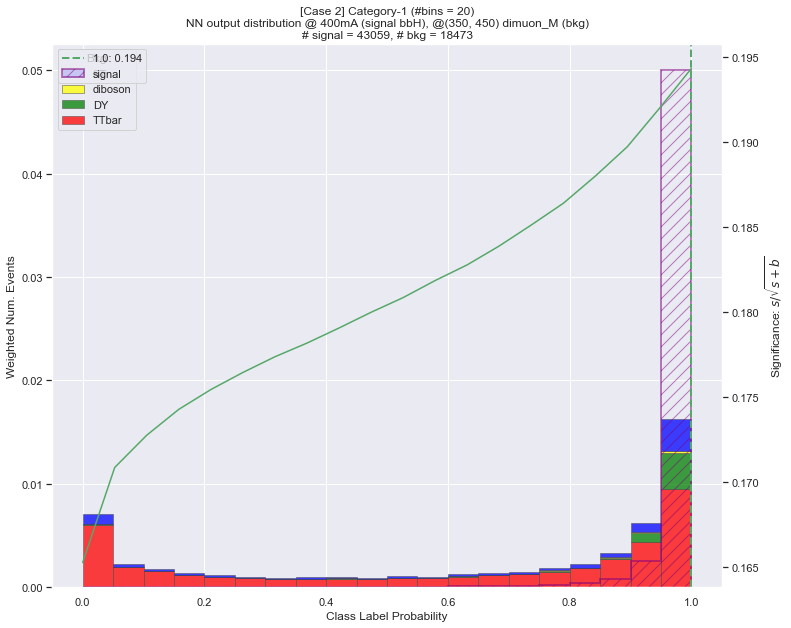

In [19]:
cmsplot(model, data, mass=400, category=1, case=2, signal='bbH')

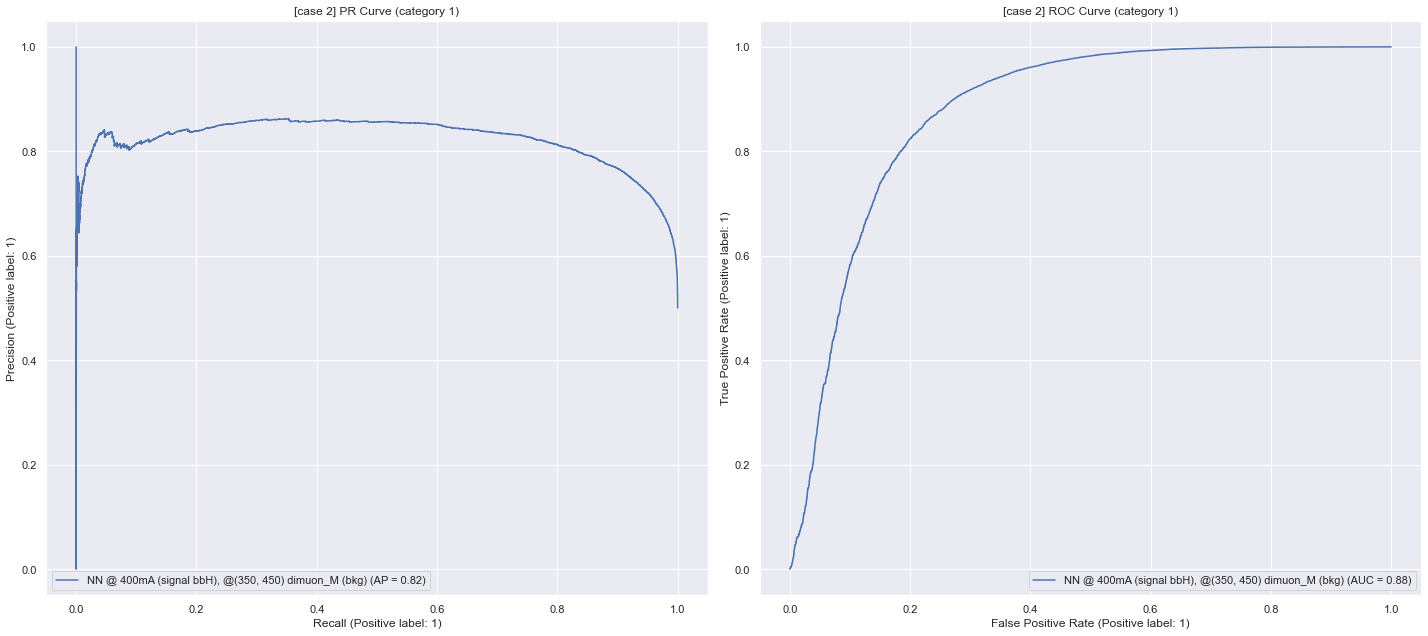

In [22]:
performance_plot(model, data, mass=400, category=1, case=2, signal='bbH')

#### Case 2

In [27]:
train_ds, valid_ds, (x_test, y_test, w_test) = get_data(data, mass=400, variables=VAR_CAT1, case=2, batch=256)

In [28]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_1-case_2-weighted')

In [29]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
145/145 - 5s - loss: 0.0220 - binary_accuracy: 0.7816 - auc: 0.7942 - precision: 0.7710 - recall: 0.9779 - class-loss: 0.0745 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 1.2186 - weight-norm: 20.4748 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0441 - val_binary_accuracy: 0.8229 - val_auc: 0.9110 - val_precision: 0.8021 - val_recall: 0.9935
Epoch 2/100
145/145 - 6s - loss: 0.0142 - binary_accuracy: 0.8171 - auc: 0.8961 - precision: 0.7984 - recall: 0.9879 - class-loss: 0.0462 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.8074 - weight-norm: 20.5715 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0498 - val_binary_accuracy: 0.7867 - val_auc: 0.9069 - val_precision: 0.7676 - val_recall: 0.9992
Epoch 3/100
145/145 - 6s - loss: 0.1470 - binary_accuracy: 0.8243 - auc: 0.9170 - precision: 0.8038 - recall: 0.9901 - class-loss: 0.0437 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.5984 - weight-norm: 20.6573 - adversar

Epoch 23/100
145/145 - 6s - loss: 0.0205 - binary_accuracy: 0.8446 - auc: 0.9442 - precision: 0.8218 - recall: 0.9928 - class-loss: 0.0350 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2147 - weight-norm: 22.5259 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0372 - val_binary_accuracy: 0.8484 - val_auc: 0.9466 - val_precision: 0.8253 - val_recall: 0.9948
Epoch 24/100
145/145 - 6s - loss: 0.0615 - binary_accuracy: 0.8465 - auc: 0.9450 - precision: 0.8238 - recall: 0.9927 - class-loss: 0.0353 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2151 - weight-norm: 22.6687 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0371 - val_binary_accuracy: 0.8443 - val_auc: 0.9496 - val_precision: 0.8215 - val_recall: 0.9959
Epoch 25/100
145/145 - 6s - loss: 0.0194 - binary_accuracy: 0.8438 - auc: 0.9456 - precision: 0.8211 - recall: 0.9929 - class-loss: 0.0347 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2058 - weight-norm: 22.7903 - adver

Epoch 45/100
145/145 - 6s - loss: 0.0285 - binary_accuracy: 0.8580 - auc: 0.9503 - precision: 0.8348 - recall: 0.9933 - class-loss: 0.0324 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2084 - weight-norm: 25.8011 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0366 - val_binary_accuracy: 0.8715 - val_auc: 0.9533 - val_precision: 0.8512 - val_recall: 0.9909
Epoch 46/100
145/145 - 6s - loss: 0.0491 - binary_accuracy: 0.8580 - auc: 0.9512 - precision: 0.8350 - recall: 0.9931 - class-loss: 0.0323 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2036 - weight-norm: 25.9636 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0374 - val_binary_accuracy: 0.8513 - val_auc: 0.9497 - val_precision: 0.8281 - val_recall: 0.9956
Epoch 47/100
145/145 - 6s - loss: 0.0240 - binary_accuracy: 0.8566 - auc: 0.9500 - precision: 0.8334 - recall: 0.9935 - class-loss: 0.0324 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2113 - weight-norm: 26.1474 - adver

Epoch 67/100
145/145 - 6s - loss: 0.0230 - binary_accuracy: 0.8627 - auc: 0.9535 - precision: 0.8396 - recall: 0.9934 - class-loss: 0.0301 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2211 - weight-norm: 30.0182 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0377 - val_binary_accuracy: 0.8685 - val_auc: 0.9498 - val_precision: 0.8473 - val_recall: 0.9917
Epoch 68/100
145/145 - 6s - loss: 0.0357 - binary_accuracy: 0.8637 - auc: 0.9531 - precision: 0.8407 - recall: 0.9931 - class-loss: 0.0301 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2365 - weight-norm: 30.2229 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0367 - val_binary_accuracy: 0.8727 - val_auc: 0.9558 - val_precision: 0.8521 - val_recall: 0.9912
Epoch 69/100
145/145 - 6s - loss: 0.0273 - binary_accuracy: 0.8642 - auc: 0.9543 - precision: 0.8410 - recall: 0.9937 - class-loss: 0.0296 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2282 - weight-norm: 30.4397 - adver

Epoch 89/100
145/145 - 6s - loss: 0.0175 - binary_accuracy: 0.8742 - auc: 0.9582 - precision: 0.8508 - recall: 0.9943 - class-loss: 0.0264 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2606 - weight-norm: 34.5062 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0409 - val_binary_accuracy: 0.8663 - val_auc: 0.9455 - val_precision: 0.8464 - val_recall: 0.9894
Epoch 90/100
145/145 - 6s - loss: 0.0306 - binary_accuracy: 0.8717 - auc: 0.9566 - precision: 0.8484 - recall: 0.9940 - class-loss: 0.0271 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2768 - weight-norm: 34.7078 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0415 - val_binary_accuracy: 0.8669 - val_auc: 0.9452 - val_precision: 0.8479 - val_recall: 0.9882


In [30]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_1-case_2-weighted')

Loaded from "weights\new/nn-400-bbH-cat_1-case_2-weighted\weights-68-0.956"


In [31]:
_ = model.evaluate(x=dict(x=x_test, m=np.zeros_like(y_test)), y=y_test, batch_size=1024, verbose=2)

13/13 - 0s - loss: 0.3341 - binary_accuracy: 0.8659 - auc: 0.9528 - precision: 0.8452 - recall: 0.9892


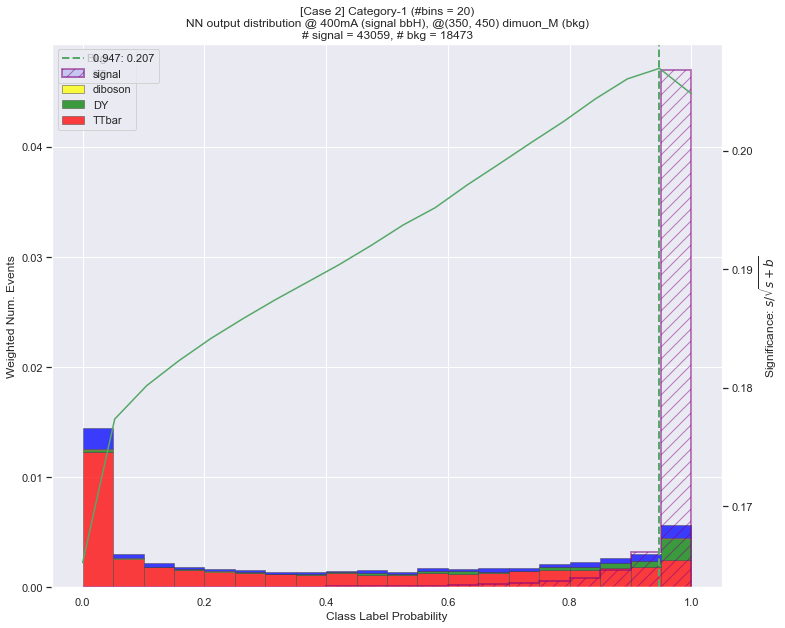

In [32]:
cmsplot(model, data, mass=400, category=1, case=2, signal='bbH')

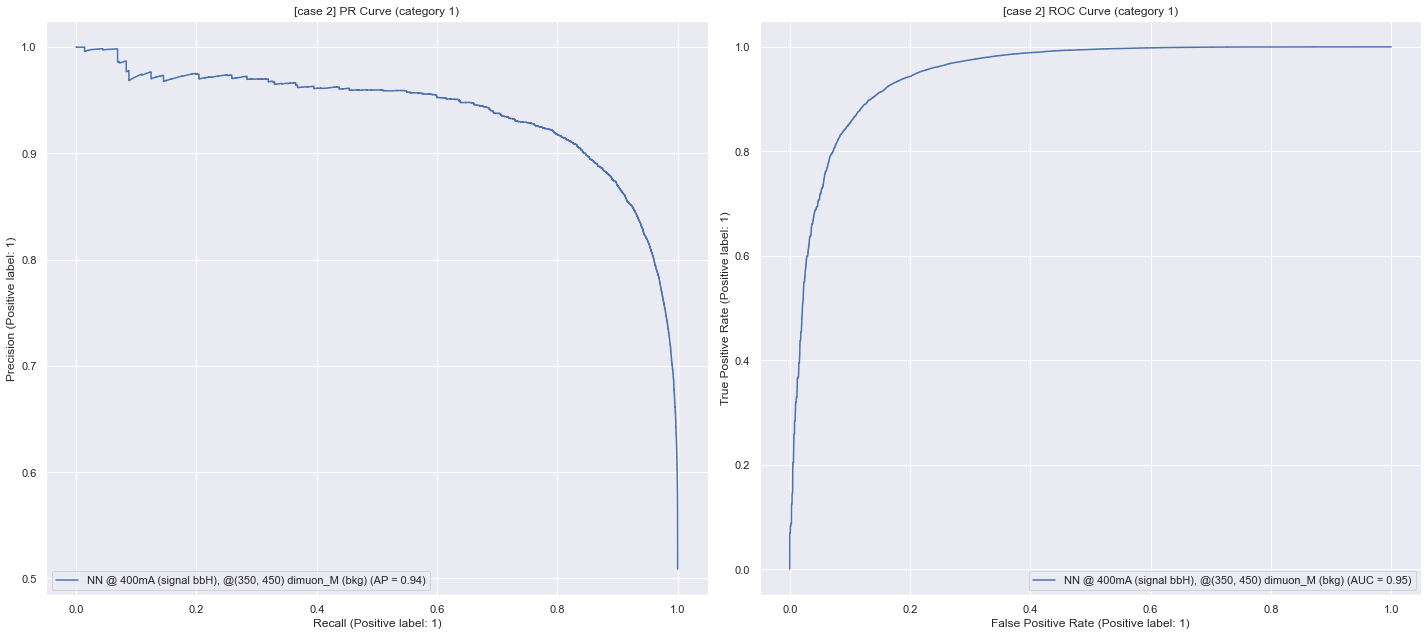

In [33]:
performance_plot(model, data, mass=400, category=1, case=2, signal='bbH')

Comparison:

In [11]:
model1 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model1, path='new/nn-400-bbH-cat_1-case_1-weighted')

model2 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model2, path='new/nn-400-bbH-cat_1-case_2-weighted')

Loaded from "weights\new/nn-400-bbH-cat_1-case_1-weighted\weights-77-0.967"
Loaded from "weights\new/nn-400-bbH-cat_1-case_2-weighted\weights-68-0.956"


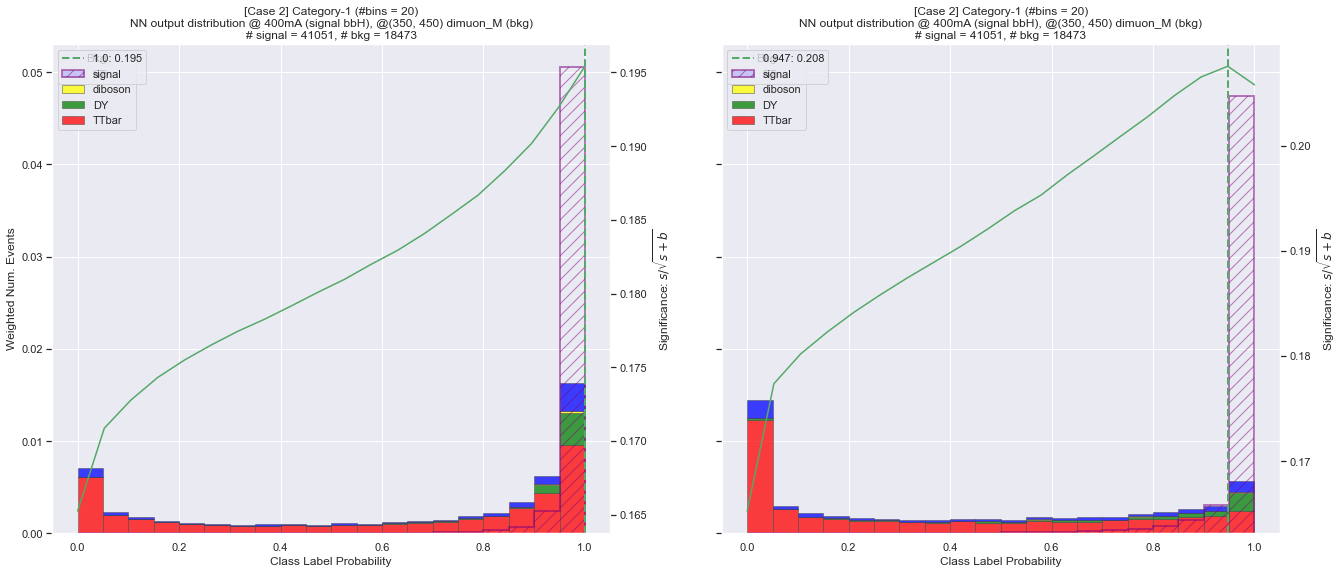

In [44]:
compare_significance([model1, model2], data, 400, category=1, signal='bbH', size=(11, 9),
                     path='plot/plot/category 1/bbH/performance/weighted', save='comparison_significance')

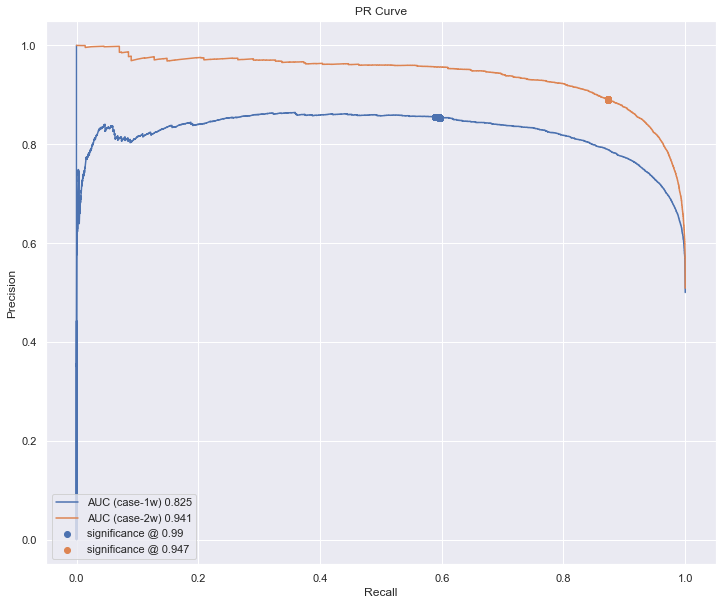

In [45]:
plot_pr(data, models_and_cuts={'case-1w': (model1, 0.99), 'case-2w': (model2, 0.947)},
        path='plot/plot/category 1/bbH/performance/weighted', save='precision_recall_curve')

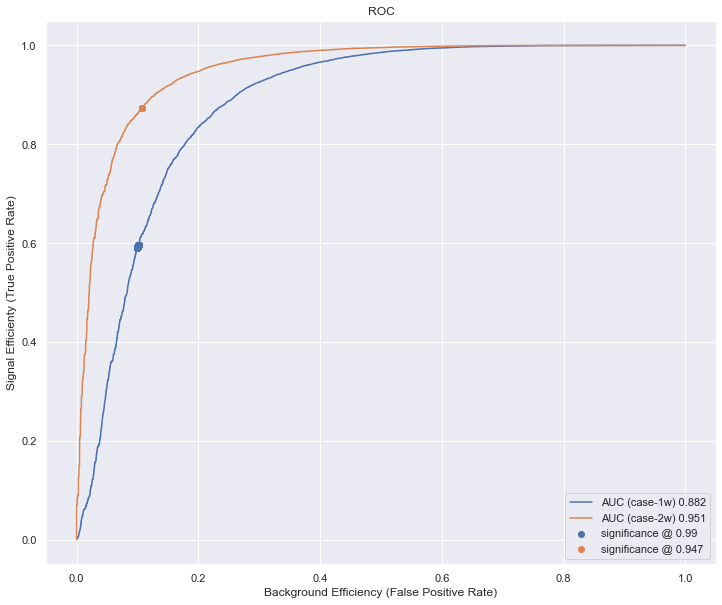

In [46]:
plot_roc(data, models_and_cuts={'case-1w': (model1, 0.99), 'case-2w': (model2, 0.947)},
         path='plot/plot/category 1/bbH/performance/weighted', save='ROC_curve')

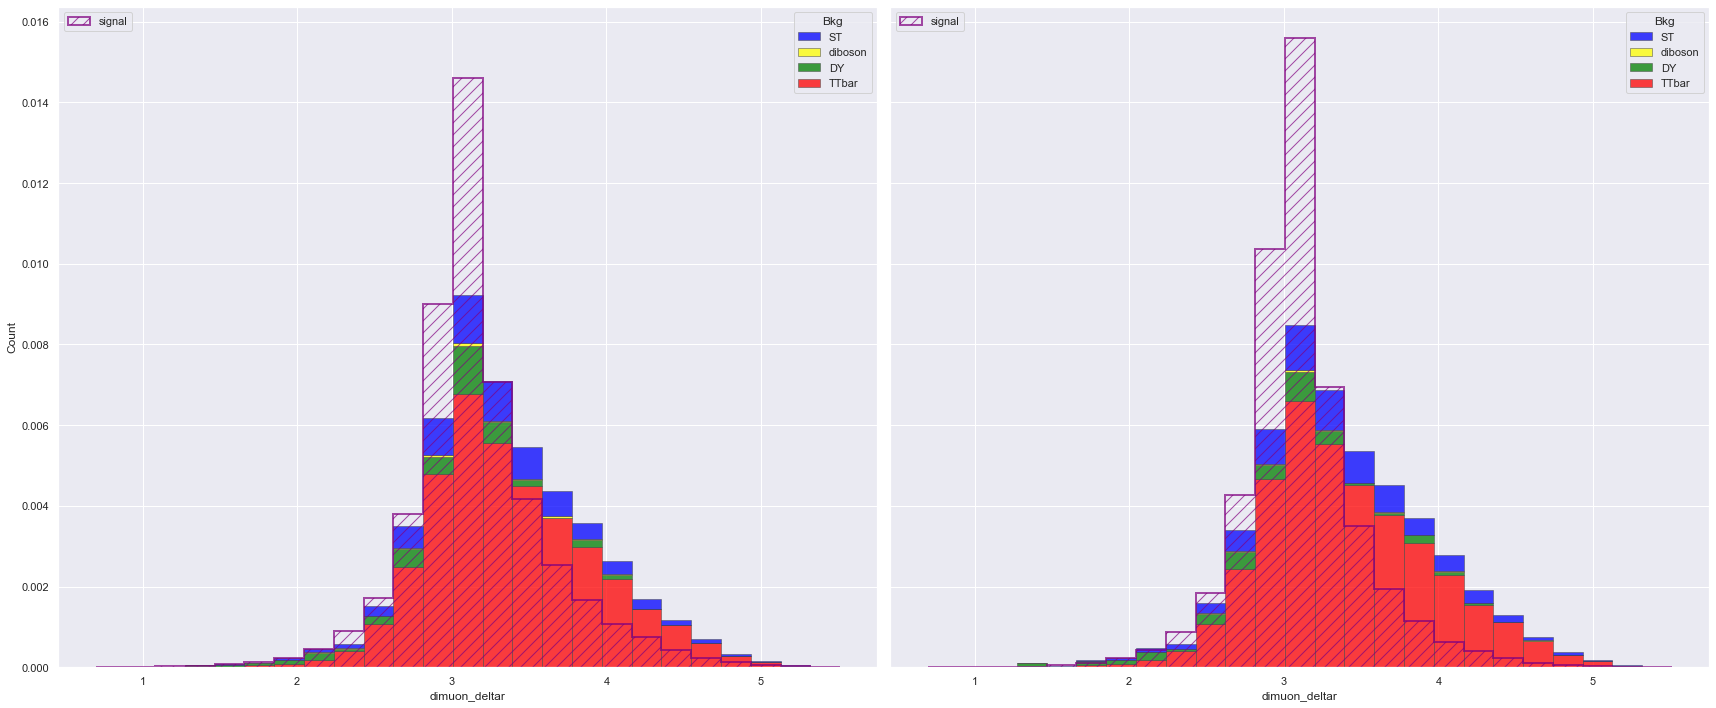

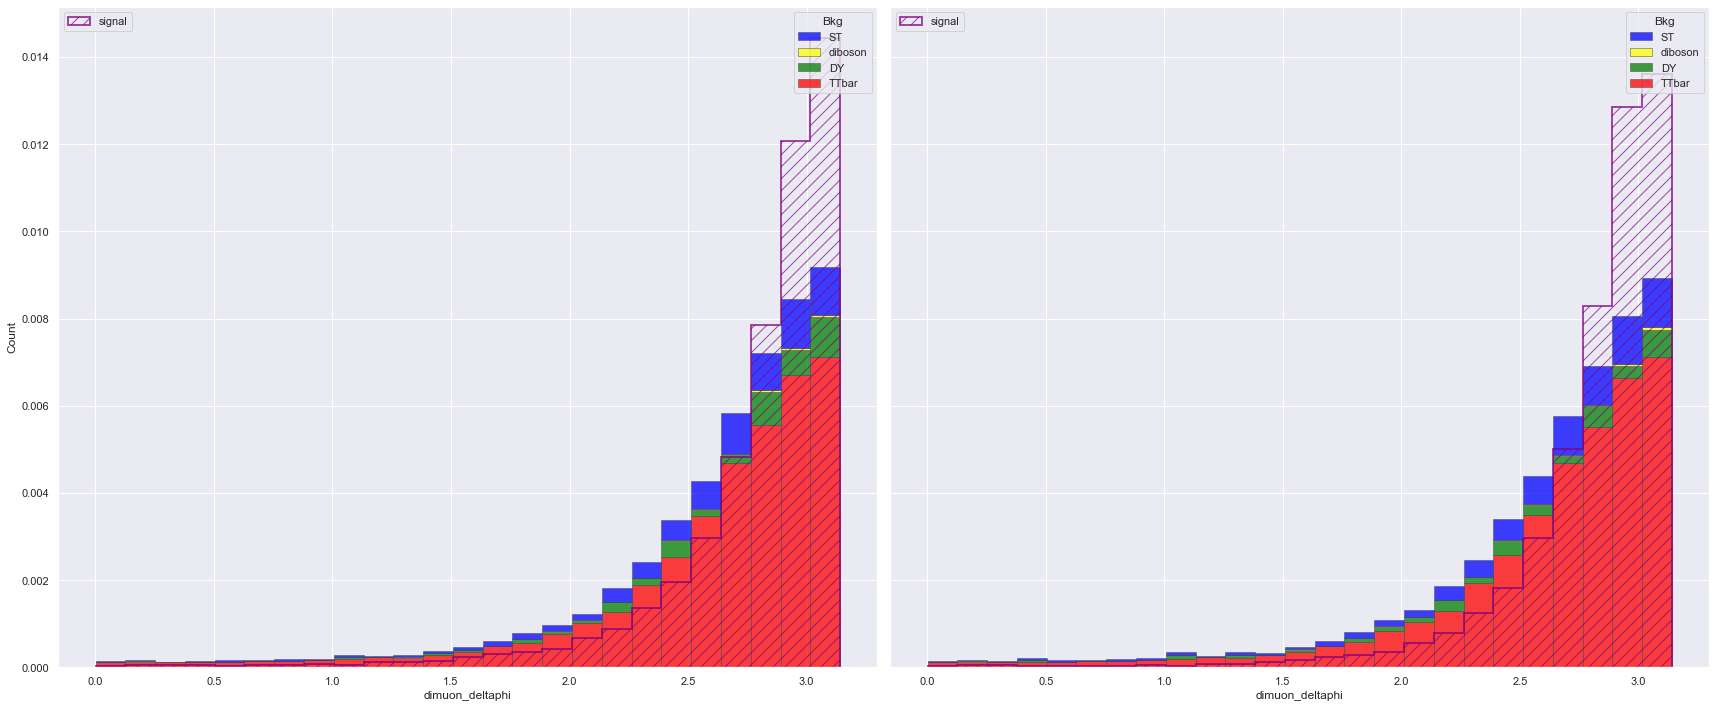

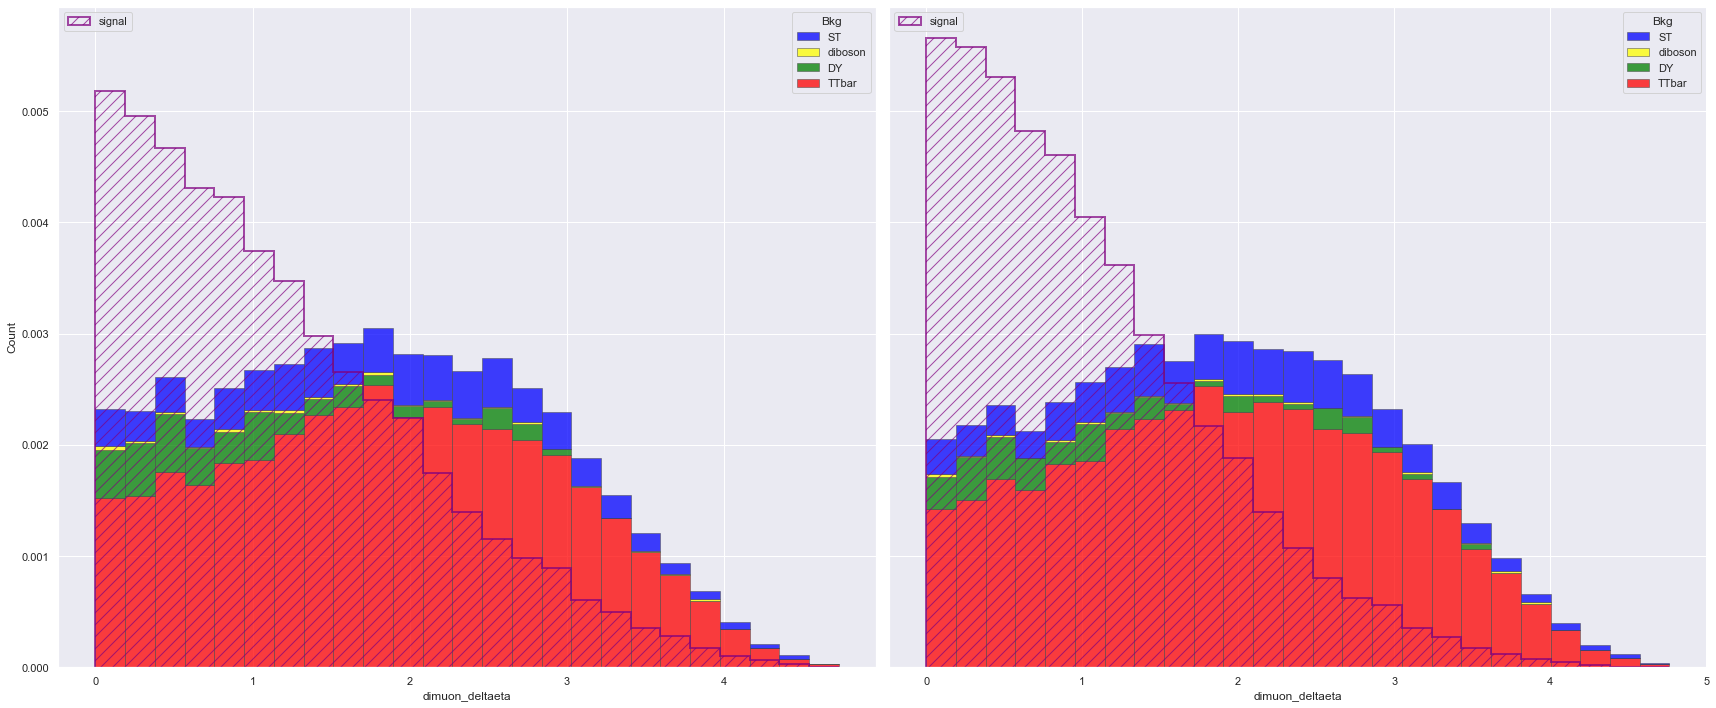

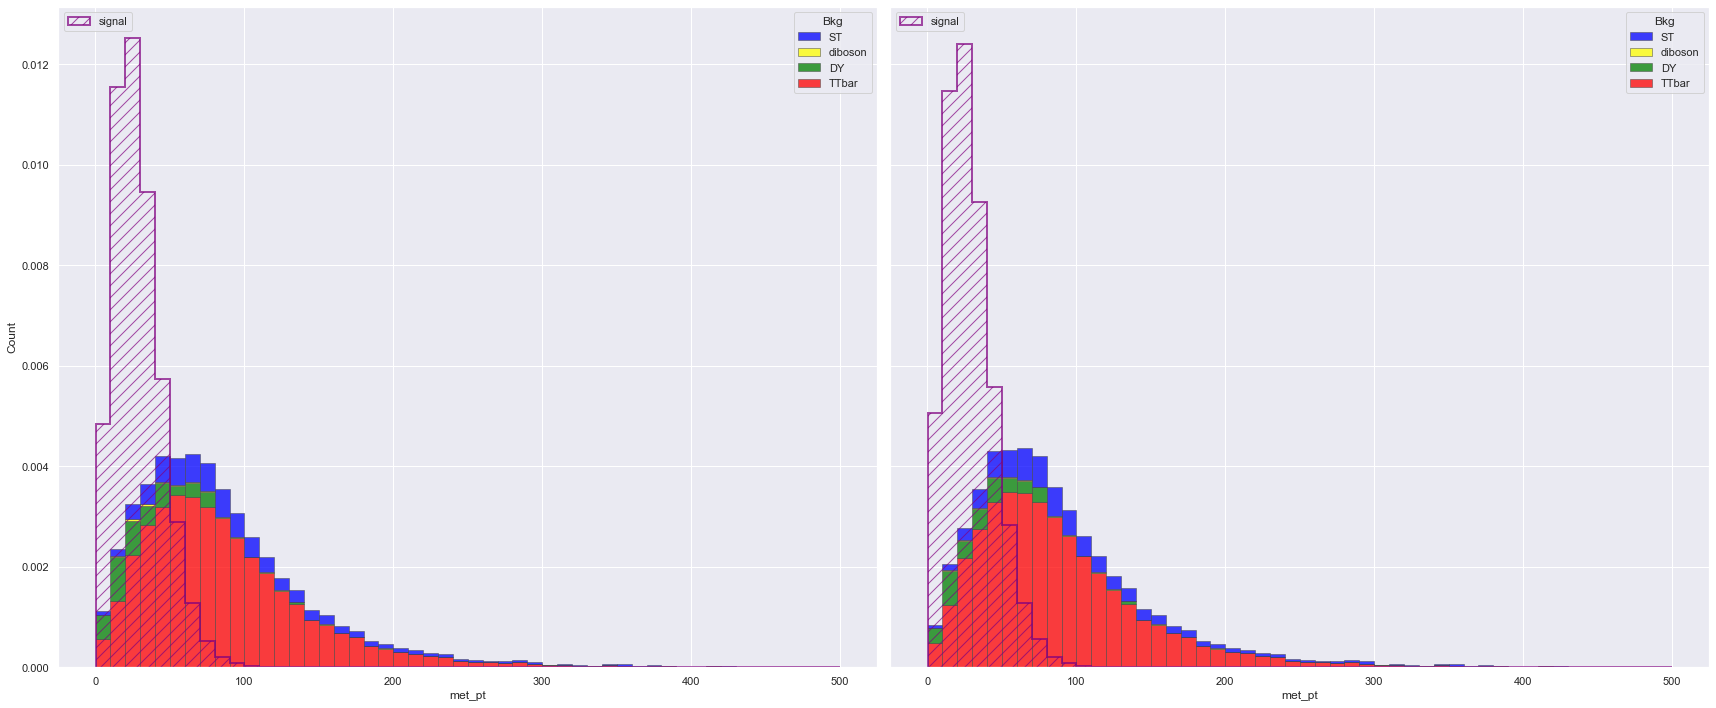

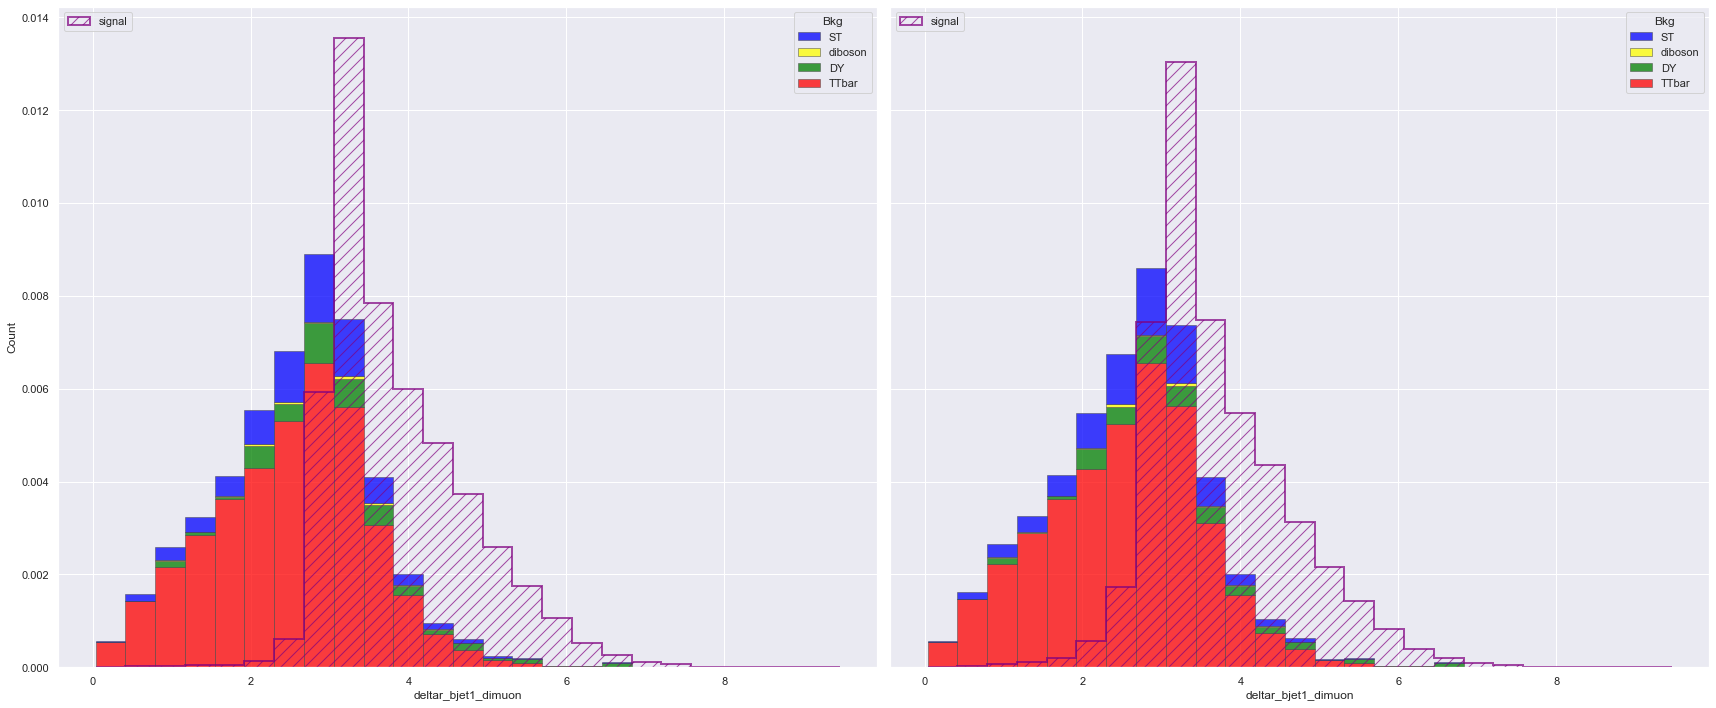

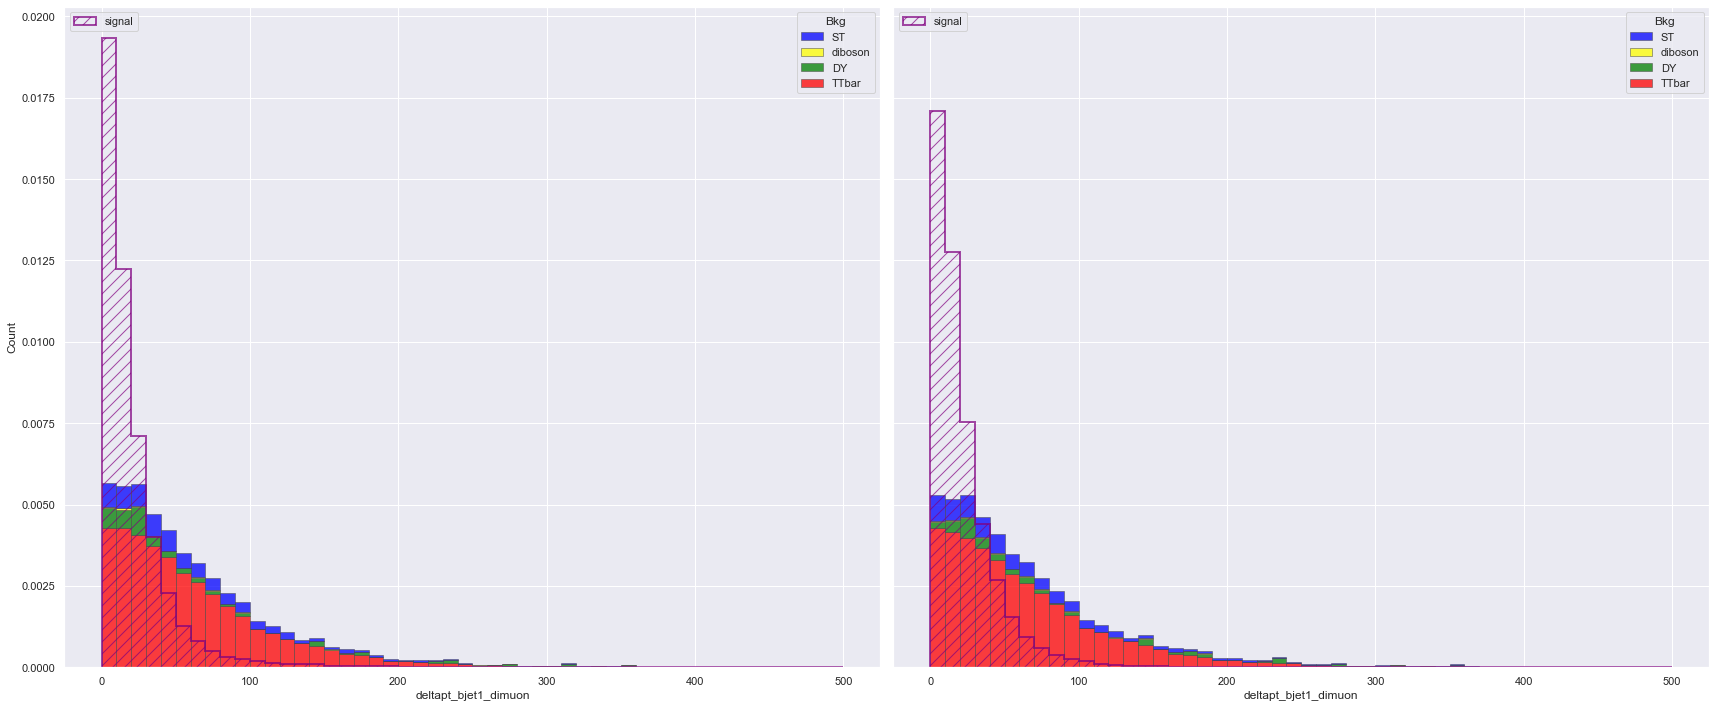

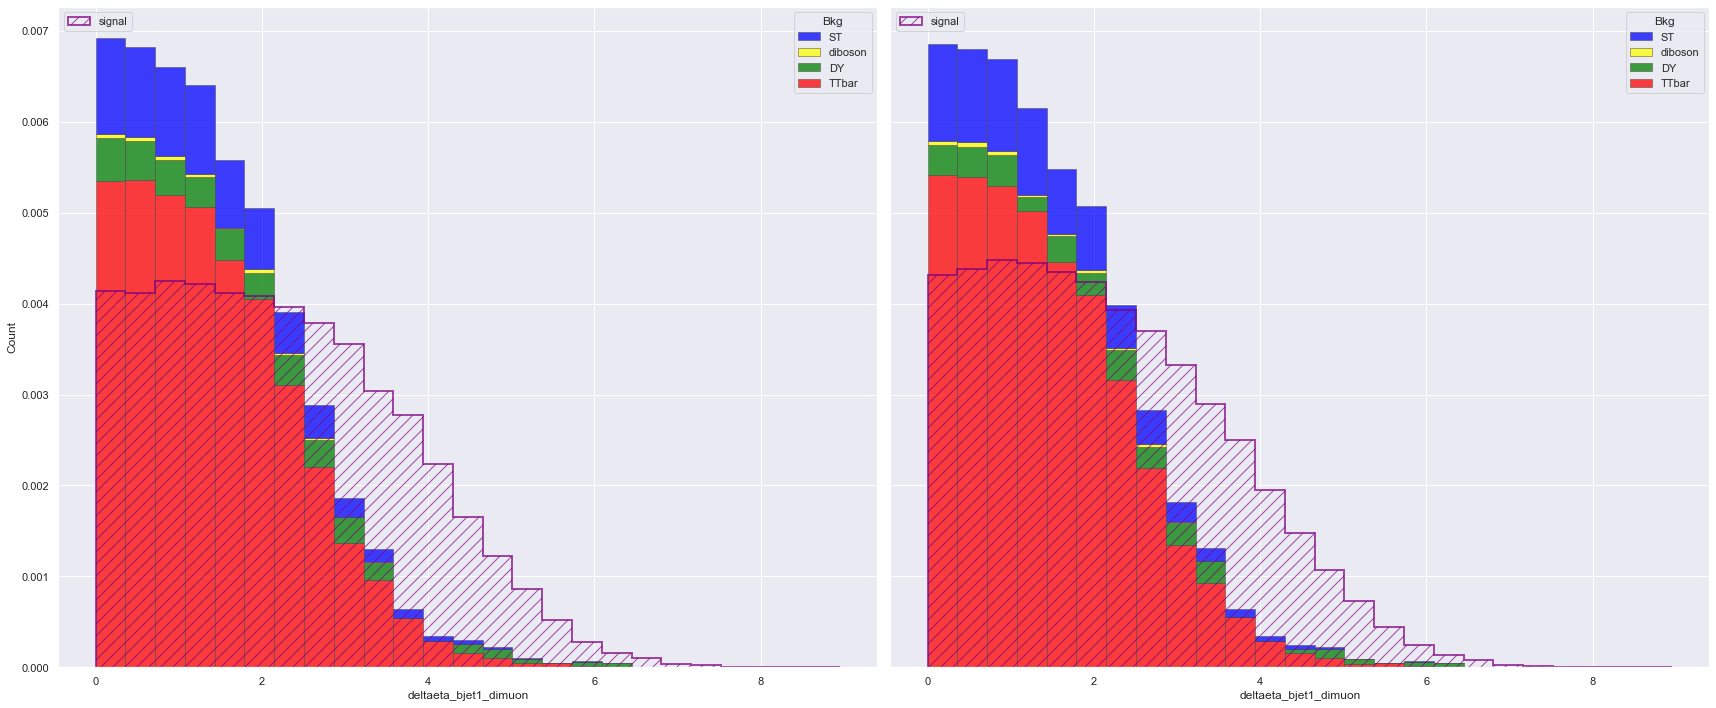

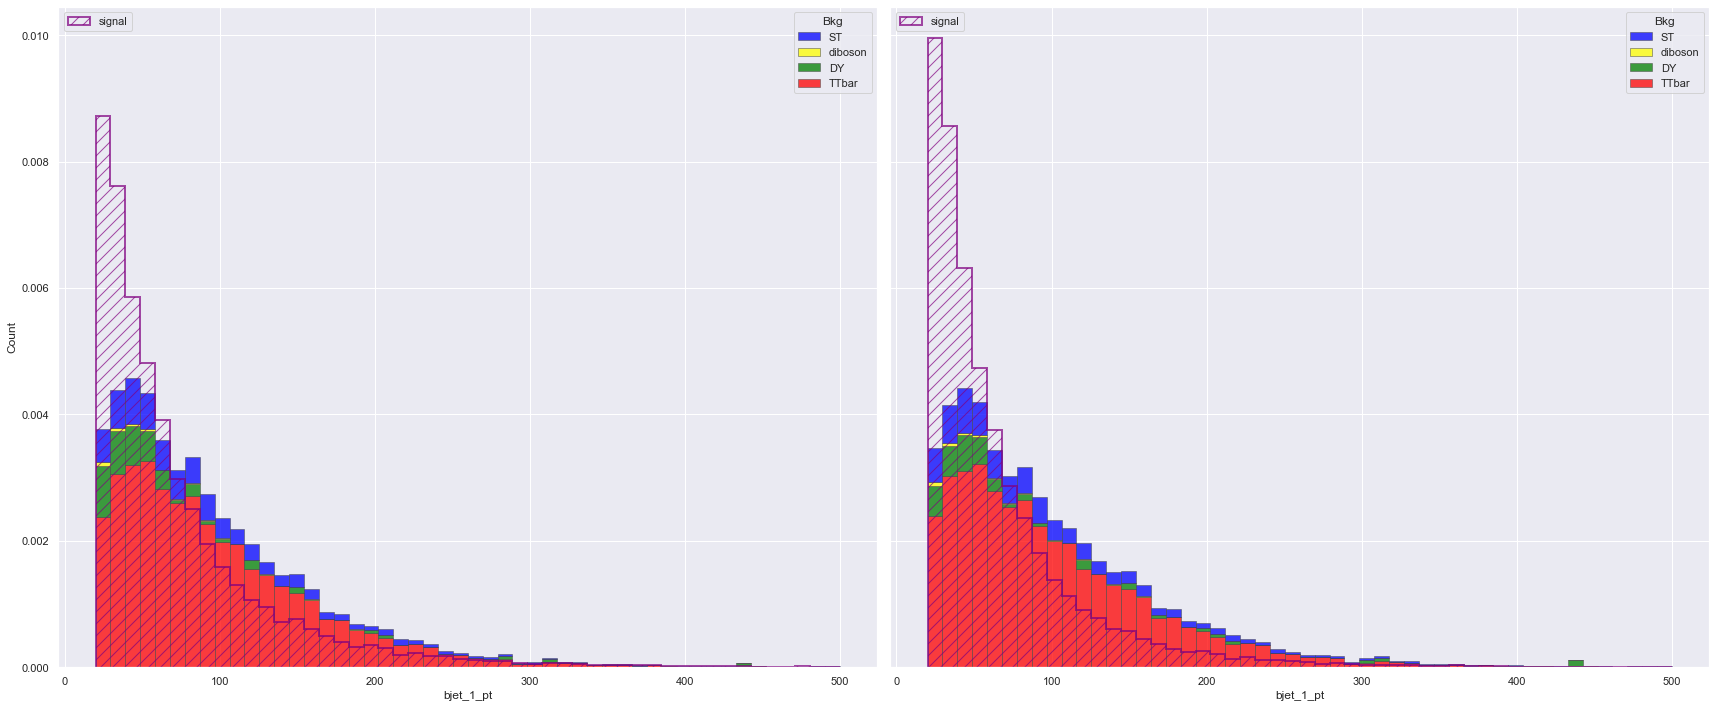

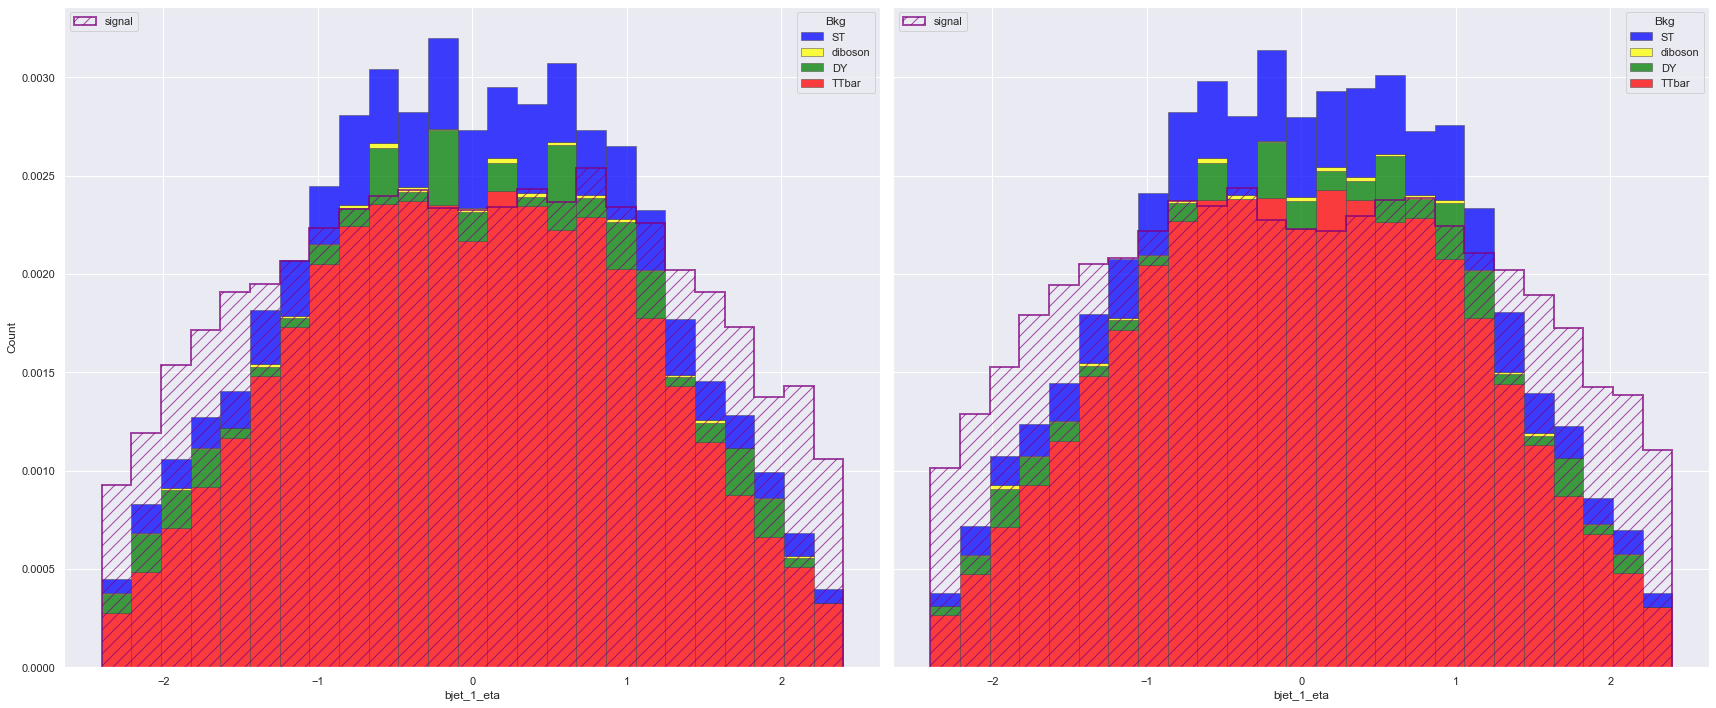

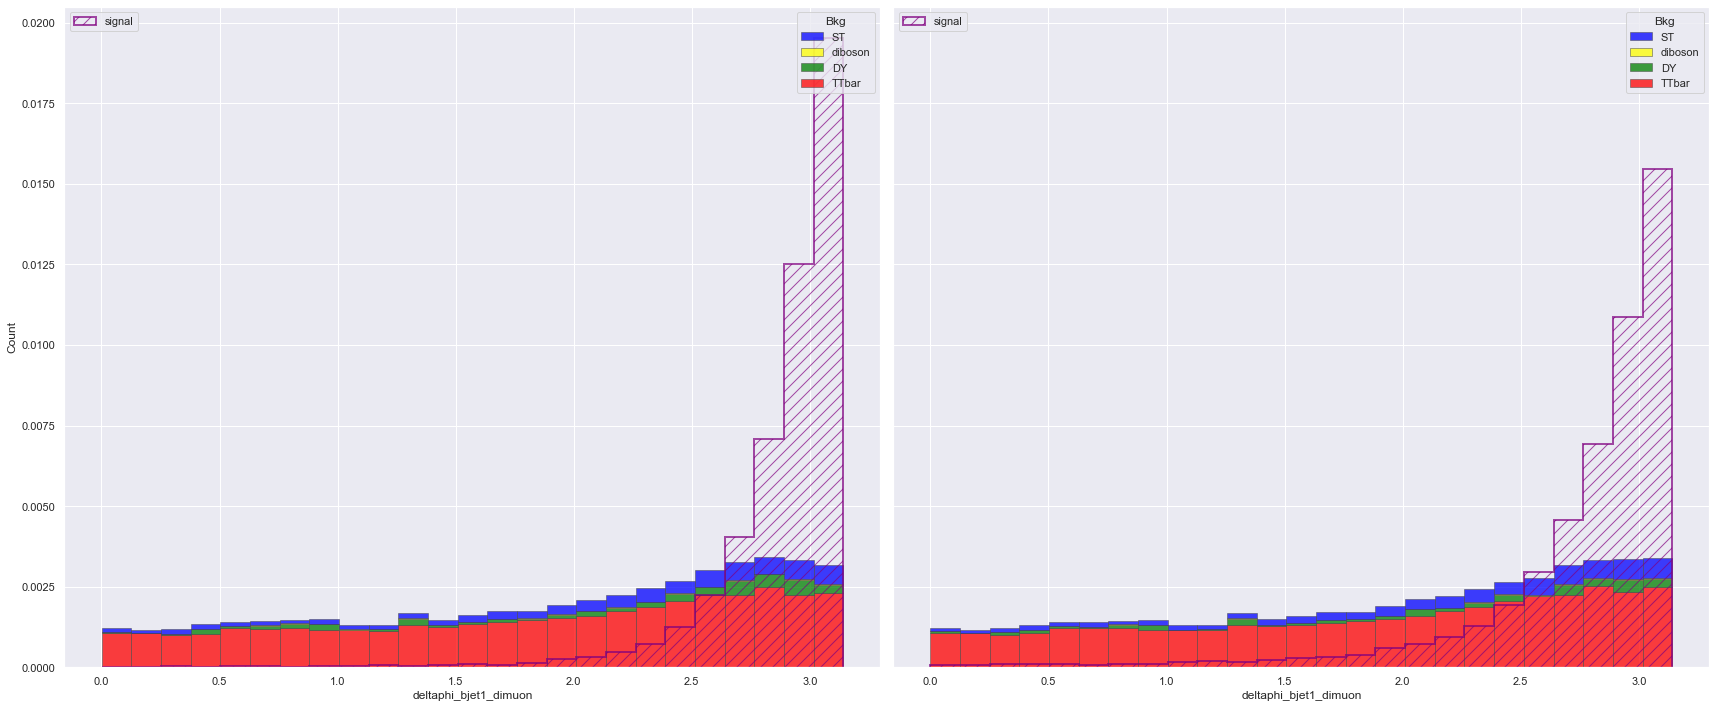

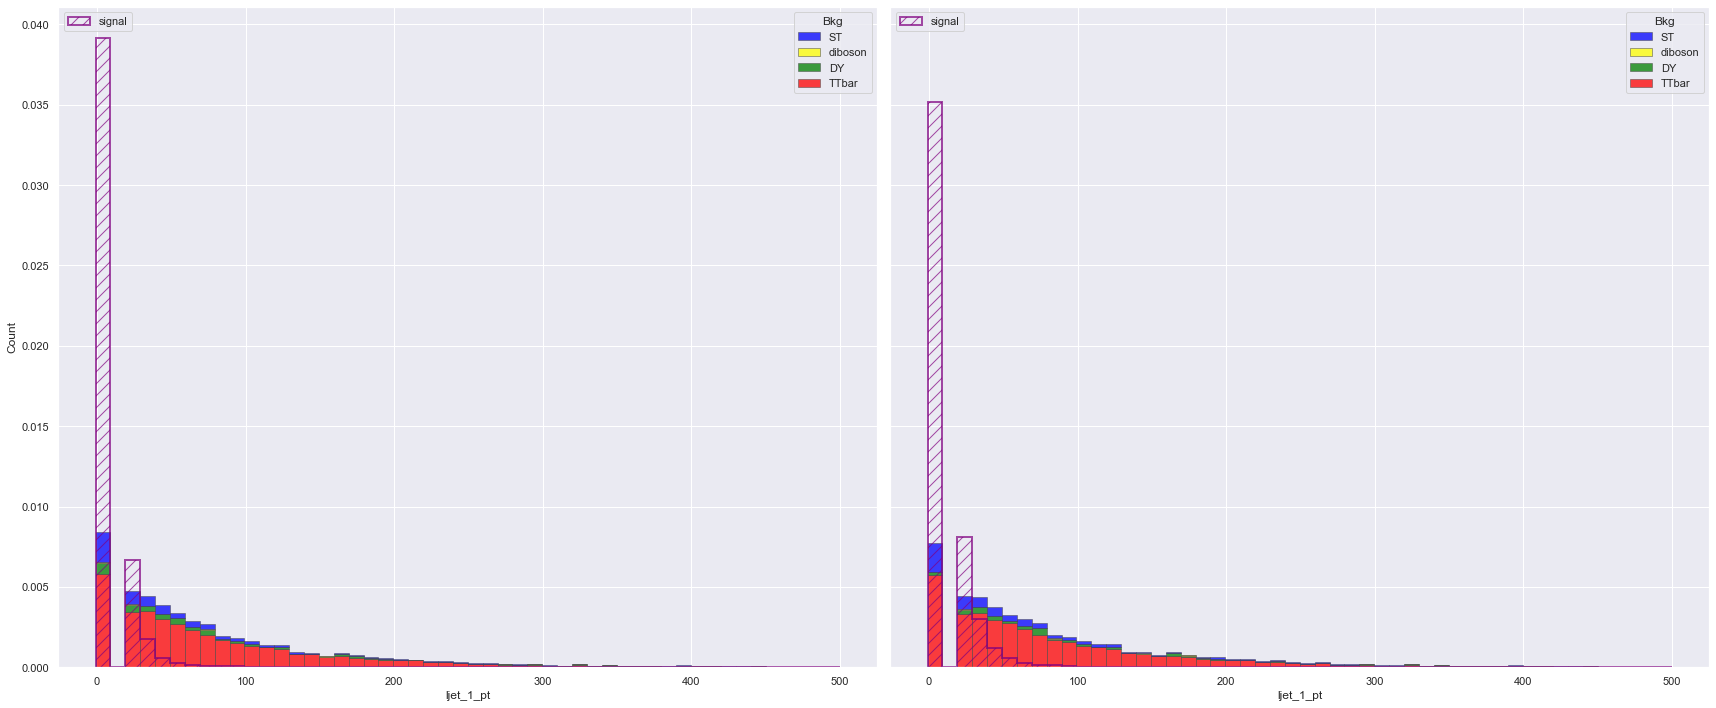

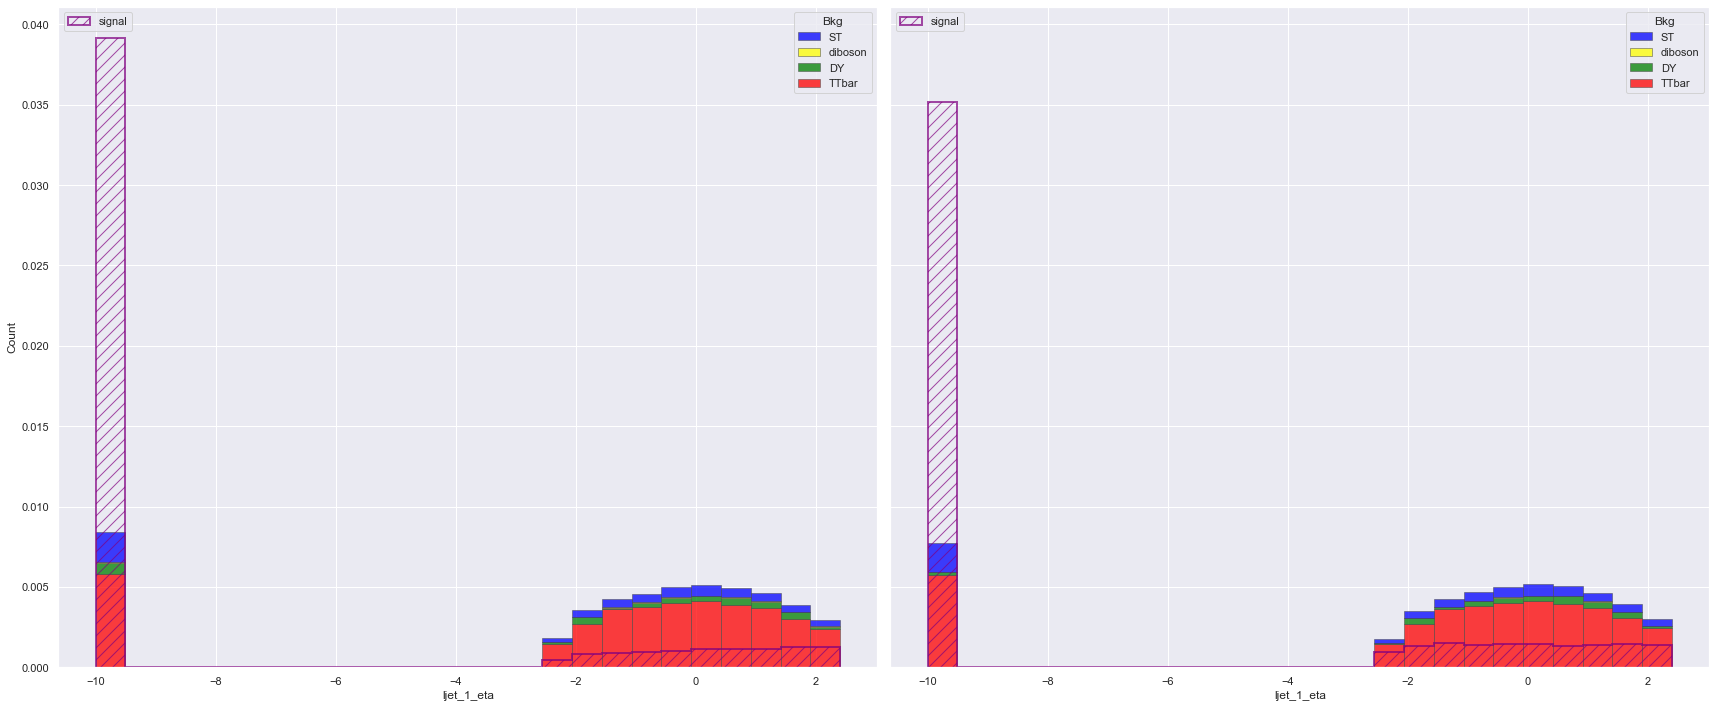

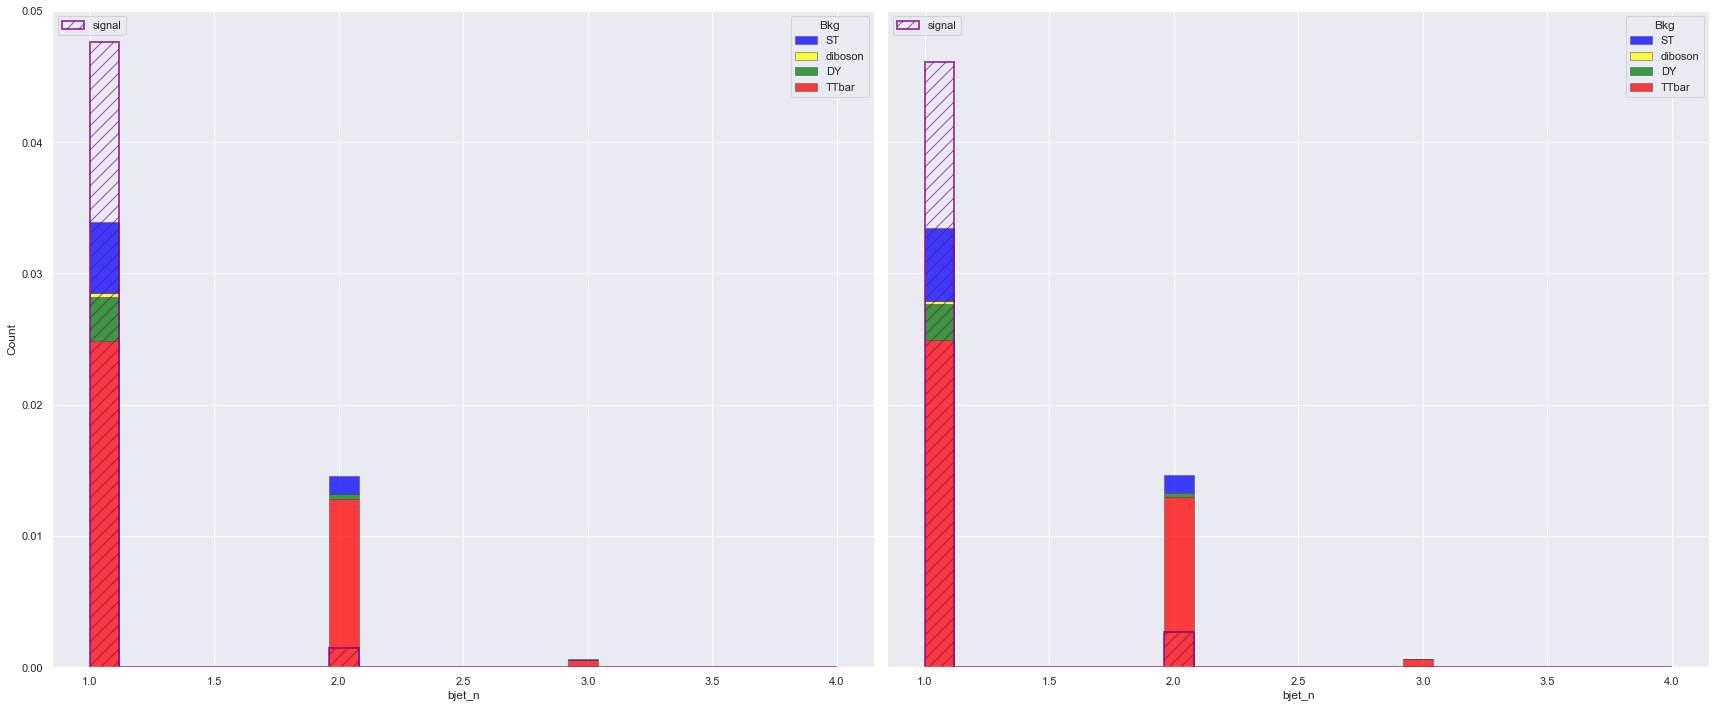

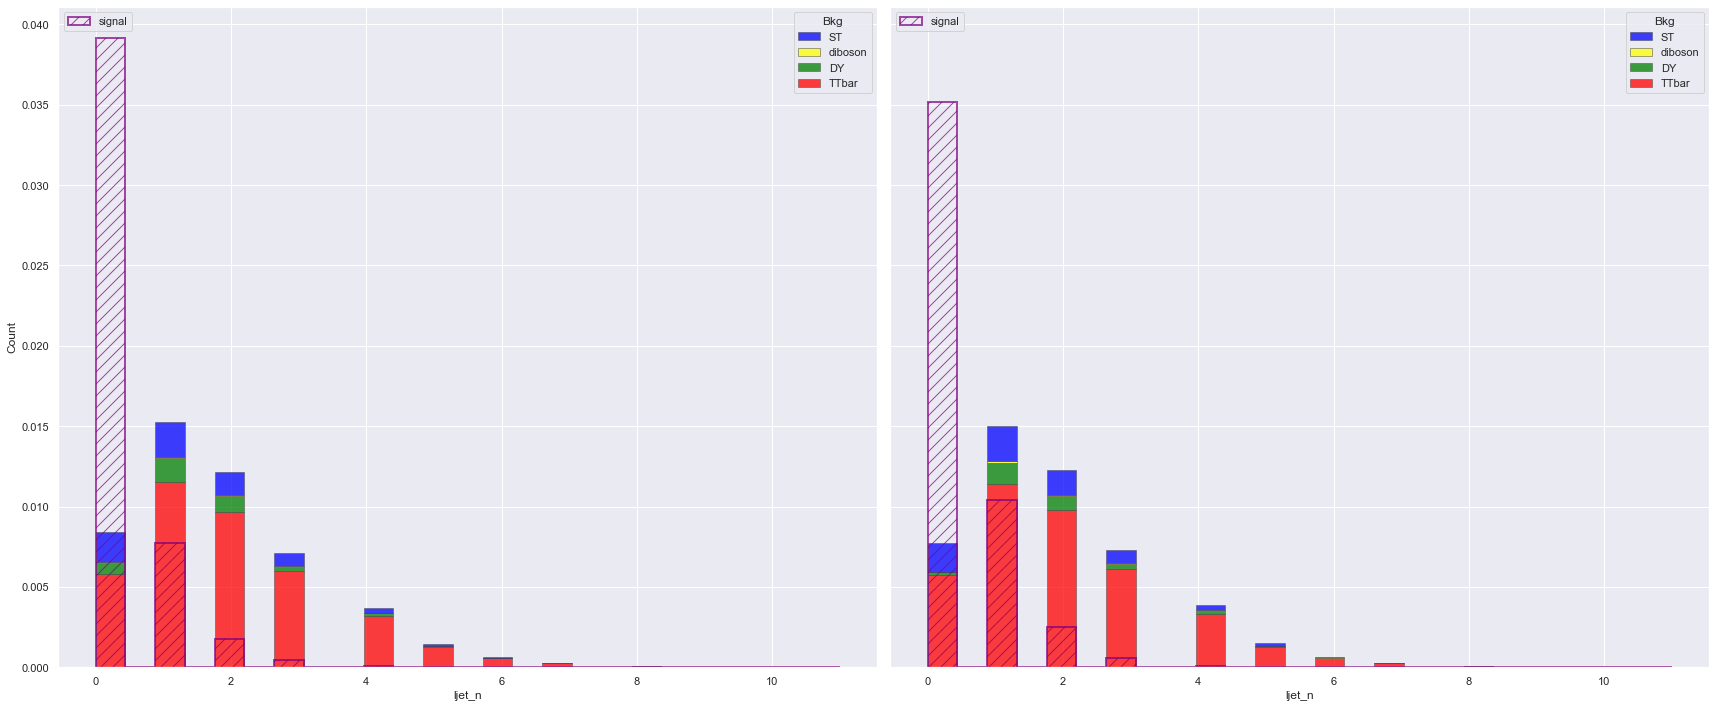

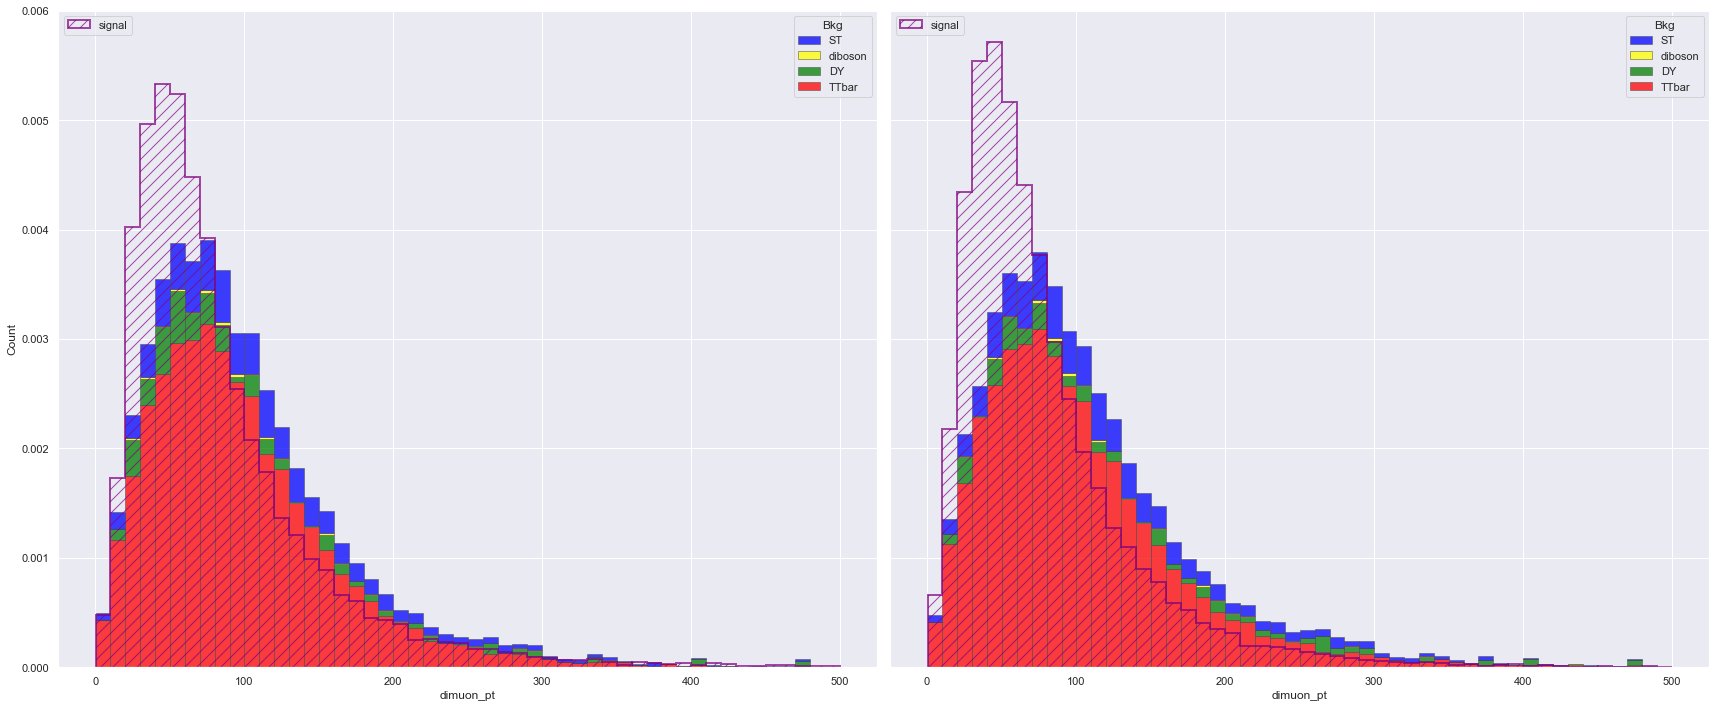

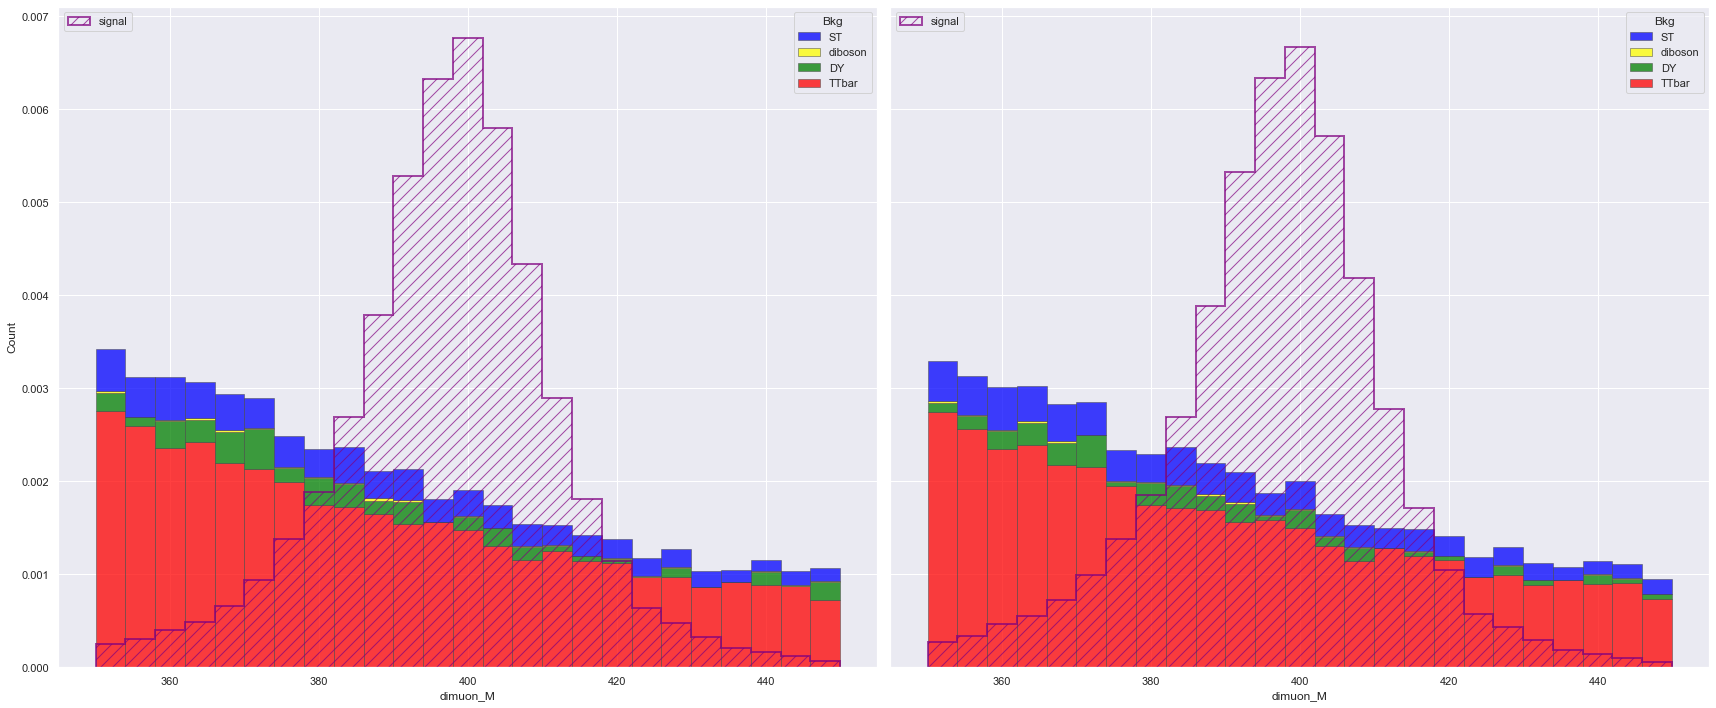

In [12]:
posteriori_plot(data, models=(model1, model2), 
                variables=VAR_CAT1 + ['dimuon_pt', 'dimuon_M'], mass=400.0, 
                cuts=(0.99, 0.947), category=1, case=2, weight=True,
                path='plot/plot/category 1/bbH/performance/weighted', save='comparison')

## Category 2
### bbH

In [18]:
VAR_CAT2 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt",
            "ljet_1_pt", "ljet_1_eta", "ljet_n"]

In [19]:
data = Dataset()
data.load(signal='data/new/signal_bassociated_cat2.csv', 
          bkg='data/new/background_cat2.csv', feature_columns=VAR_CAT2)

data.ds.loc[data.ds['ljet_1_eta'] == -10, 'ljet_1_eta'] = -3.0

[signal] loading...
[background] loading...
[Dataset] loaded.


#### Case 1

In [45]:
train_ds, valid_ds, (x_test, y_test, w_test) = get_data(data, mass=400, variables=VAR_CAT2, case=1, batch=256)

In [46]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_2-case_1-weighted')

In [47]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
4410/4410 - 173s - loss: 0.9778 - binary_accuracy: 0.4041 - auc: 0.7809 - precision: 0.0907 - recall: 0.9619 - class-loss: 0.6582 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.2903 - weight-norm: 21.1522 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.6234 - val_binary_accuracy: 0.4623 - val_auc: 0.8297 - val_precision: 0.1020 - val_recall: 0.9737
Epoch 2/100
4410/4410 - 169s - loss: 0.5528 - binary_accuracy: 0.5221 - auc: 0.8177 - precision: 0.1101 - recall: 0.9556 - class-loss: 0.6135 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.7564 - weight-norm: 23.0473 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.6055 - val_binary_accuracy: 0.4602 - val_auc: 0.8236 - val_precision: 0.1024 - val_recall: 0.9822
Epoch 3/100
4410/4410 - 171s - loss: 0.7764 - binary_accuracy: 0.5294 - auc: 0.8251 - precision: 0.1118 - recall: 0.9574 - class-loss: 0.5999 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 4.4144 - weight-norm: 24.139

Epoch 22/100
4410/4410 - 169s - loss: 0.5121 - binary_accuracy: 0.5539 - auc: 0.8399 - precision: 0.1172 - recall: 0.9563 - class-loss: 0.5819 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.8386 - weight-norm: 42.7264 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5794 - val_binary_accuracy: 0.5372 - val_auc: 0.8481 - val_precision: 0.1161 - val_recall: 0.9677
Epoch 23/100
4410/4410 - 168s - loss: 0.4771 - binary_accuracy: 0.5522 - auc: 0.8399 - precision: 0.1168 - recall: 0.9561 - class-loss: 0.5819 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.7907 - weight-norm: 43.4274 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5810 - val_binary_accuracy: 0.5489 - val_auc: 0.8543 - val_precision: 0.1189 - val_recall: 0.9687
Epoch 24/100
4410/4410 - 169s - loss: 1.1327 - binary_accuracy: 0.5464 - auc: 0.8392 - precision: 0.1156 - recall: 0.9574 - class-loss: 0.5814 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.8466 - weight-norm: 44.

Epoch 43/100
4410/4410 - 236s - loss: 0.5169 - binary_accuracy: 0.5460 - auc: 0.8395 - precision: 0.1154 - recall: 0.9570 - class-loss: 0.5797 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.3620 - weight-norm: 55.8033 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5813 - val_binary_accuracy: 0.5160 - val_auc: 0.8370 - val_precision: 0.1118 - val_recall: 0.9697
Epoch 44/100
4410/4410 - 246s - loss: 0.4563 - binary_accuracy: 0.5413 - auc: 0.8394 - precision: 0.1145 - recall: 0.9579 - class-loss: 0.5792 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.3135 - weight-norm: 56.2922 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5760 - val_binary_accuracy: 0.5243 - val_auc: 0.8412 - val_precision: 0.1133 - val_recall: 0.9675
Epoch 45/100
4410/4410 - 253s - loss: 0.6379 - binary_accuracy: 0.5464 - auc: 0.8401 - precision: 0.1155 - recall: 0.9569 - class-loss: 0.5806 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.3981 - weight-norm: 56.

Epoch 64/100
4410/4410 - 194s - loss: 0.5719 - binary_accuracy: 0.5477 - auc: 0.8395 - precision: 0.1158 - recall: 0.9564 - class-loss: 0.5784 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1155 - weight-norm: 64.3439 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5765 - val_binary_accuracy: 0.5056 - val_auc: 0.8371 - val_precision: 0.1095 - val_recall: 0.9681
Epoch 65/100
4410/4410 - 192s - loss: 0.6481 - binary_accuracy: 0.5491 - auc: 0.8395 - precision: 0.1161 - recall: 0.9568 - class-loss: 0.5785 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1289 - weight-norm: 64.7625 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5758 - val_binary_accuracy: 0.5377 - val_auc: 0.8497 - val_precision: 0.1163 - val_recall: 0.9686
Epoch 66/100
4410/4410 - 192s - loss: 0.3649 - binary_accuracy: 0.5534 - auc: 0.8404 - precision: 0.1170 - recall: 0.9556 - class-loss: 0.5796 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.1293 - weight-norm: 65.

Epoch 85/100
4410/4410 - 164s - loss: 0.6554 - binary_accuracy: 0.5575 - auc: 0.8422 - precision: 0.1180 - recall: 0.9561 - class-loss: 0.5777 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9815 - weight-norm: 71.6336 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5785 - val_binary_accuracy: 0.5099 - val_auc: 0.8498 - val_precision: 0.1111 - val_recall: 0.9759
Epoch 86/100
4410/4410 - 164s - loss: 0.3434 - binary_accuracy: 0.5372 - auc: 0.8378 - precision: 0.1134 - recall: 0.9559 - class-loss: 0.5801 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 3.0617 - weight-norm: 72.1422 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.5798 - val_binary_accuracy: 0.5229 - val_auc: 0.8408 - val_precision: 0.1131 - val_recall: 0.9687
Epoch 87/100
4410/4410 - 163s - loss: 0.3242 - binary_accuracy: 0.5552 - auc: 0.8411 - precision: 0.1175 - recall: 0.9564 - class-loss: 0.5779 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 2.9506 - weight-norm: 72.

In [48]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_2-case_1-weighted')

Loaded from "weights\new/nn-400-bbH-cat_2-case_1-weighted\weights-29-0.858"


In [50]:
_ = model.evaluate(x=dict(x=x_test, m=np.zeros_like(y_test)), y=y_test, batch_size=1024, verbose=2)

368/368 - 8s - loss: 0.7949 - binary_accuracy: 0.5643 - auc: 0.8556 - precision: 0.1208 - recall: 0.9638


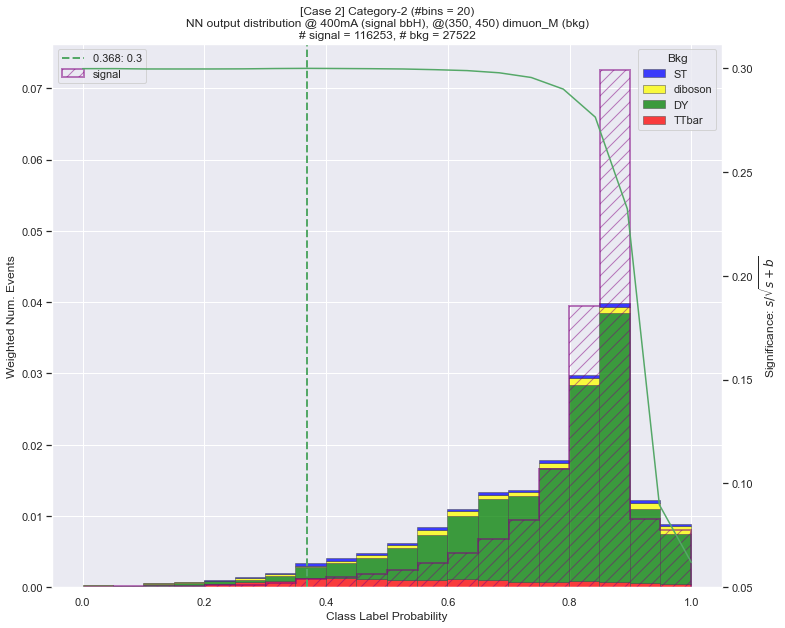

In [51]:
cmsplot(model, data, mass=400, category=2, case=2, signal='bbH')

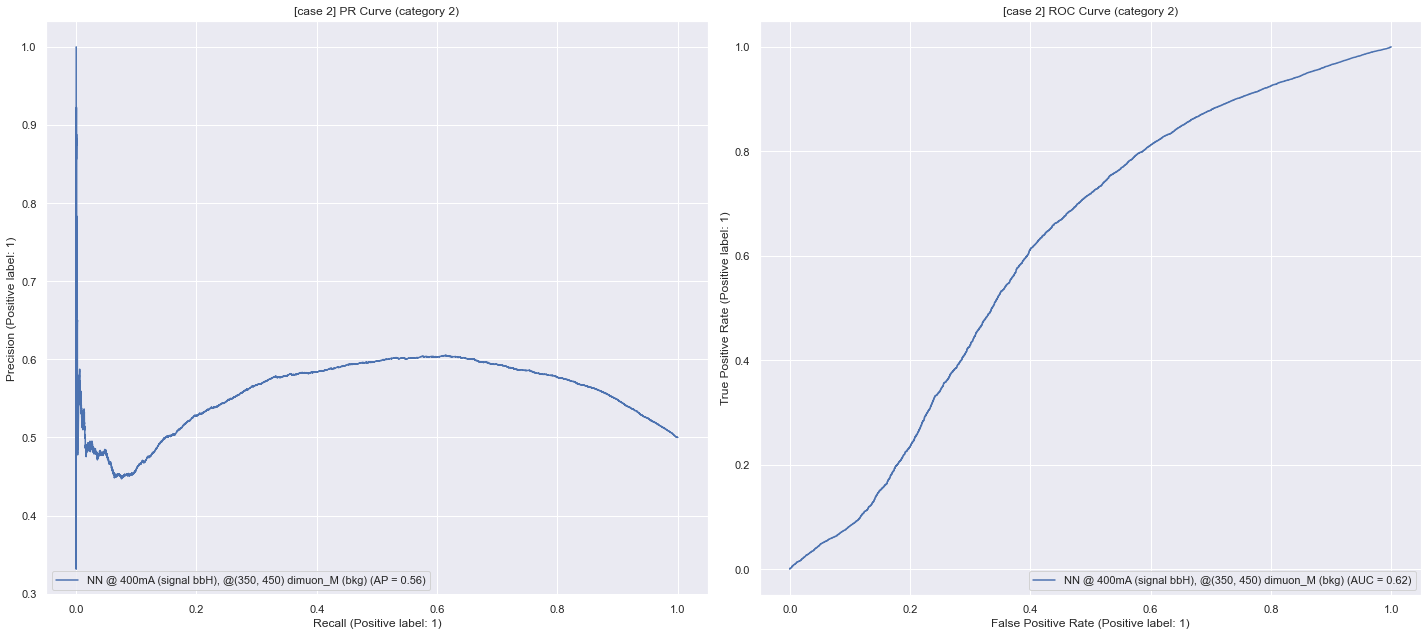

In [52]:
performance_plot(model, data, mass=400, category=2, case=2, signal='bbH')

#### Case 2

In [53]:
train_ds, valid_ds, (x_test, y_test, w_test) = get_data(data, mass=400, variables=VAR_CAT2, case=2, batch=256)

In [54]:
# create model
model, checkpoint = utils.get_compiled_non_parametric(data, save='new/nn-400-bbH-cat_2-case_2-weighted')

In [55]:
model.fit(x=train_ds, epochs=100, validation_data=valid_ds, verbose=2,
          callbacks=[checkpoint, EarlyStopping(patience=40)])

Epoch 1/100
337/337 - 13s - loss: 0.0844 - binary_accuracy: 0.8264 - auc: 0.7539 - precision: 0.8309 - recall: 0.9861 - class-loss: 0.0748 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.3328 - weight-norm: 20.1978 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0755 - val_binary_accuracy: 0.8716 - val_auc: 0.8788 - val_precision: 0.9052 - val_recall: 0.9395
Epoch 2/100
337/337 - 13s - loss: 0.0852 - binary_accuracy: 0.8483 - auc: 0.8405 - precision: 0.8470 - recall: 0.9916 - class-loss: 0.0703 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.2166 - weight-norm: 20.2973 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0695 - val_binary_accuracy: 0.8558 - val_auc: 0.8655 - val_precision: 0.8516 - val_recall: 0.9949
Epoch 3/100
337/337 - 13s - loss: 0.0688 - binary_accuracy: 0.8514 - auc: 0.8587 - precision: 0.8494 - recall: 0.9920 - class-loss: 0.0694 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1794 - weight-norm: 20.3851 - adver

Epoch 23/100
337/337 - 13s - loss: 0.1078 - binary_accuracy: 0.8686 - auc: 0.8730 - precision: 0.8664 - recall: 0.9903 - class-loss: 0.0679 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1060 - weight-norm: 22.5579 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0681 - val_binary_accuracy: 0.8465 - val_auc: 0.8584 - val_precision: 0.8418 - val_recall: 0.9975
Epoch 24/100
337/337 - 13s - loss: 0.0974 - binary_accuracy: 0.8713 - auc: 0.8749 - precision: 0.8688 - recall: 0.9903 - class-loss: 0.0673 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1016 - weight-norm: 22.6651 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0691 - val_binary_accuracy: 0.8444 - val_auc: 0.8522 - val_precision: 0.8401 - val_recall: 0.9973
Epoch 25/100
337/337 - 13s - loss: 0.0485 - binary_accuracy: 0.8717 - auc: 0.8746 - precision: 0.8698 - recall: 0.9895 - class-loss: 0.0673 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1044 - weight-norm: 22.7501 - ad

Epoch 45/100
337/337 - 13s - loss: 0.0740 - binary_accuracy: 0.8709 - auc: 0.8750 - precision: 0.8687 - recall: 0.9900 - class-loss: 0.0670 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1137 - weight-norm: 25.4349 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0684 - val_binary_accuracy: 0.8491 - val_auc: 0.8593 - val_precision: 0.8444 - val_recall: 0.9970
Epoch 46/100
337/337 - 13s - loss: 0.0964 - binary_accuracy: 0.8708 - auc: 0.8747 - precision: 0.8688 - recall: 0.9897 - class-loss: 0.0671 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1166 - weight-norm: 25.5894 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0681 - val_binary_accuracy: 0.8528 - val_auc: 0.8587 - val_precision: 0.8489 - val_recall: 0.9950
Epoch 47/100
337/337 - 12s - loss: 0.0739 - binary_accuracy: 0.8712 - auc: 0.8752 - precision: 0.8690 - recall: 0.9900 - class-loss: 0.0670 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1168 - weight-norm: 25.7603 - ad

Epoch 67/100
337/337 - 13s - loss: 0.0742 - binary_accuracy: 0.8717 - auc: 0.8729 - precision: 0.8702 - recall: 0.9888 - class-loss: 0.0664 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1308 - weight-norm: 29.5095 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0685 - val_binary_accuracy: 0.8545 - val_auc: 0.8525 - val_precision: 0.8523 - val_recall: 0.9916
Epoch 68/100
337/337 - 13s - loss: 0.0652 - binary_accuracy: 0.8705 - auc: 0.8738 - precision: 0.8687 - recall: 0.9895 - class-loss: 0.0666 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1360 - weight-norm: 29.7284 - adversarial-loss: 0.0000e+00 - reg-losses: 0.0000e+00 - val_loss: 0.0692 - val_binary_accuracy: 0.8410 - val_auc: 0.8574 - val_precision: 0.8378 - val_recall: 0.9962
Epoch 69/100
337/337 - 13s - loss: 0.0874 - binary_accuracy: 0.8700 - auc: 0.8743 - precision: 0.8686 - recall: 0.9888 - class-loss: 0.0666 - fool-loss: 0.0000e+00 - lr: 0.0010 - grad-norm: 0.1305 - weight-norm: 29.9373 - ad

In [56]:
utils.load_from_checkpoint(model, path='new/nn-400-bbH-cat_2-case_2-weighted')

Loaded from "weights\new/nn-400-bbH-cat_2-case_2-weighted\weights-05-0.879"


In [57]:
_ = model.evaluate(x=dict(x=x_test, m=np.zeros_like(y_test)), y=y_test, batch_size=1024, verbose=2)

29/29 - 1s - loss: 0.3199 - binary_accuracy: 0.8813 - auc: 0.8745 - precision: 0.8936 - recall: 0.9685


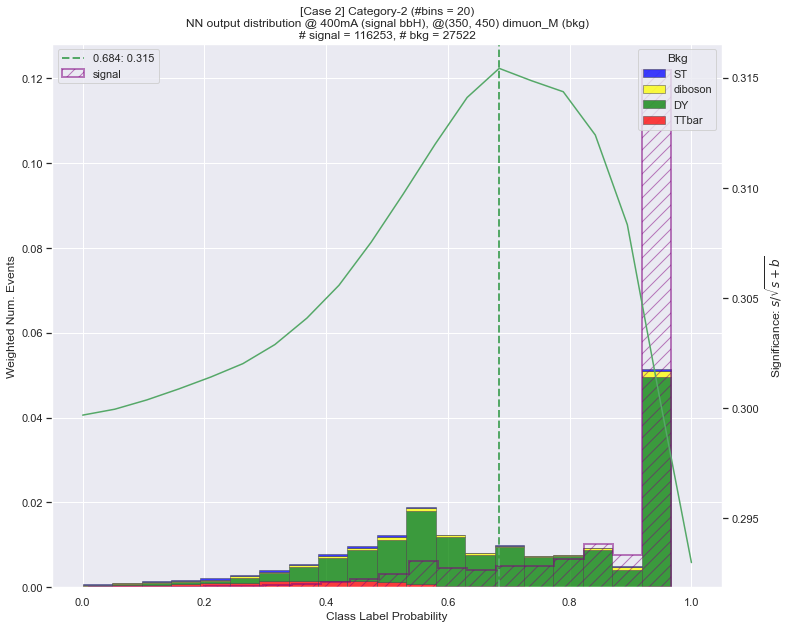

In [58]:
cmsplot(model, data, mass=400, category=2, case=2, signal='bbH')

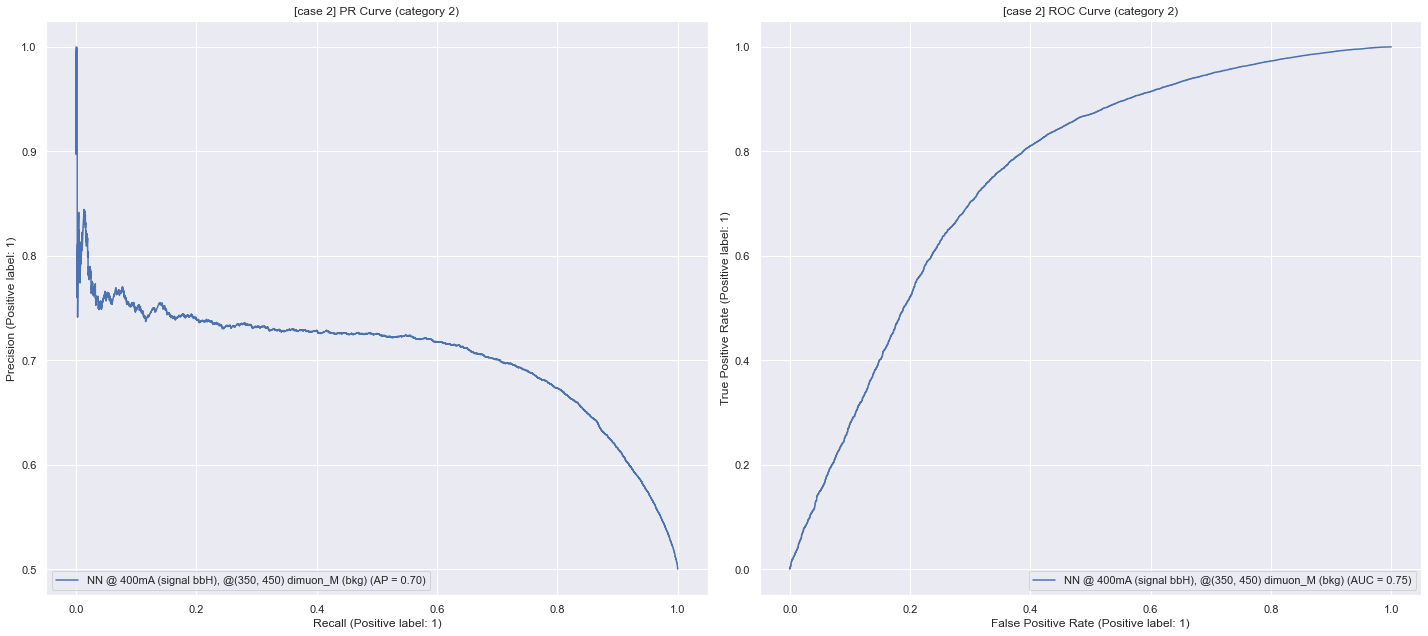

In [59]:
performance_plot(model, data, mass=400, category=2, case=2, signal='bbH')

Comparison:

In [20]:
model1 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model1, path='new/nn-400-bbH-cat_2-case_1-weighted')

model2 = utils.get_compiled_non_parametric(data)
utils.load_from_checkpoint(model2, path='new/nn-400-bbH-cat_2-case_2-weighted')

Loaded from "weights\new/nn-400-bbH-cat_2-case_1-weighted\weights-29-0.858"
Loaded from "weights\new/nn-400-bbH-cat_2-case_2-weighted\weights-05-0.879"


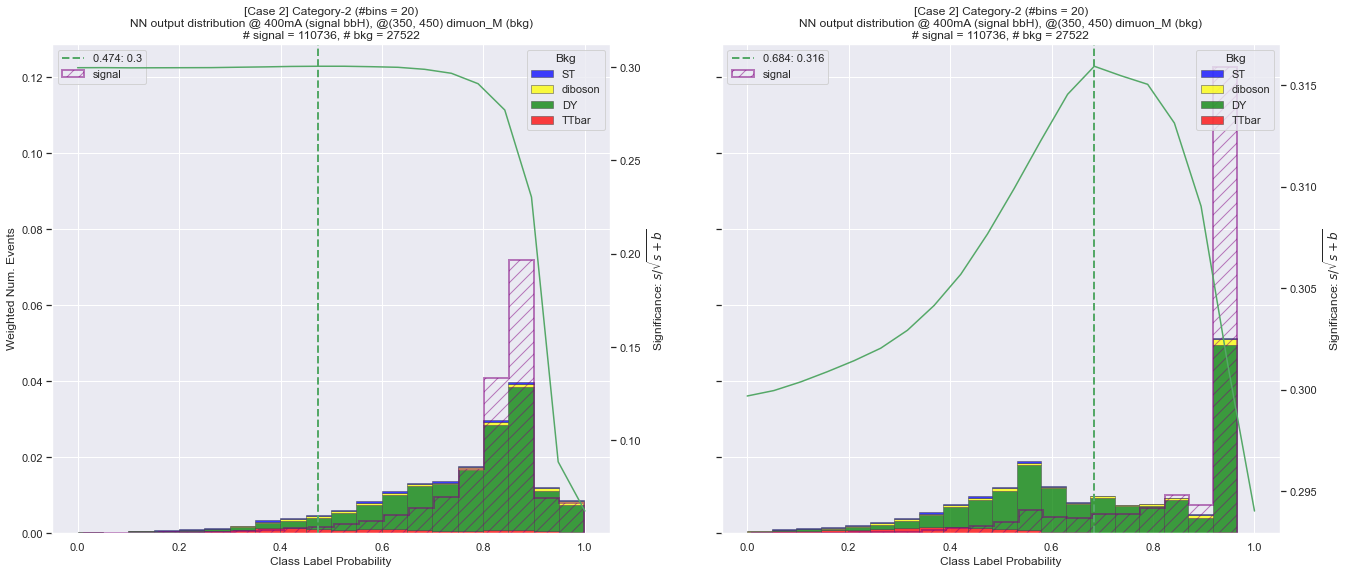

In [34]:
compare_significance([model1, model2], data, 400, category=2, signal='bbH', size=(11, 9),
                     path='plot/plot/category 2/bbH/performance/weighted', save='comparison_significance')

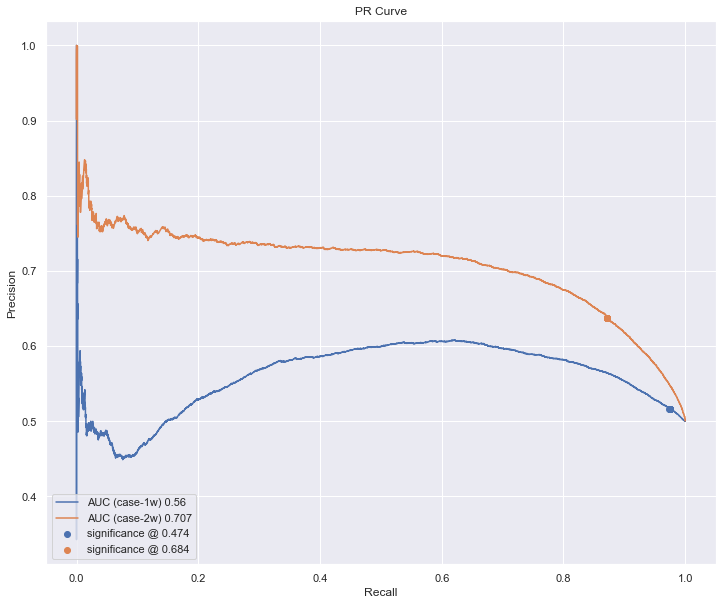

In [38]:
plot_pr(data, models_and_cuts={'case-1w': (model1, 0.474), 'case-2w': (model2, 0.684)},
        path='plot/plot/category 2/bbH/performance/weighted', save='precision_recall_curve')

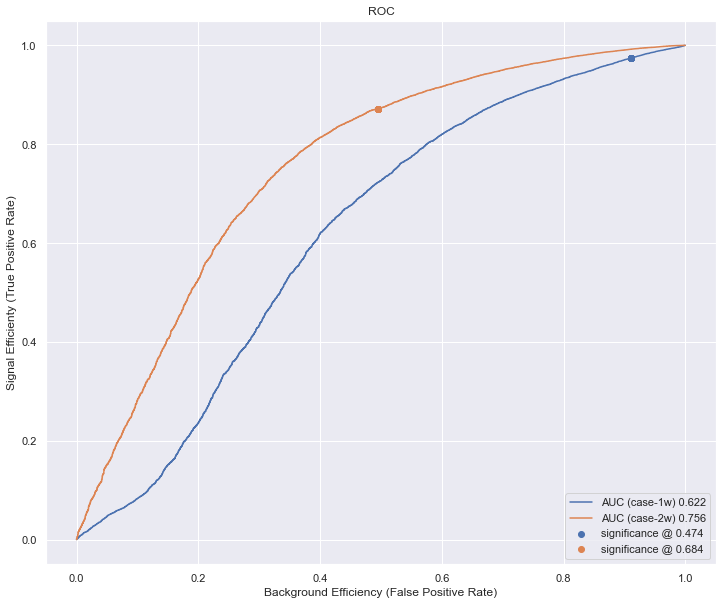

In [37]:
plot_roc(data, models_and_cuts={'case-1w': (model1, 0.474), 'case-2w': (model2, 0.684)},
         path='plot/plot/category 2/bbH/performance/weighted', save='ROC_curve')

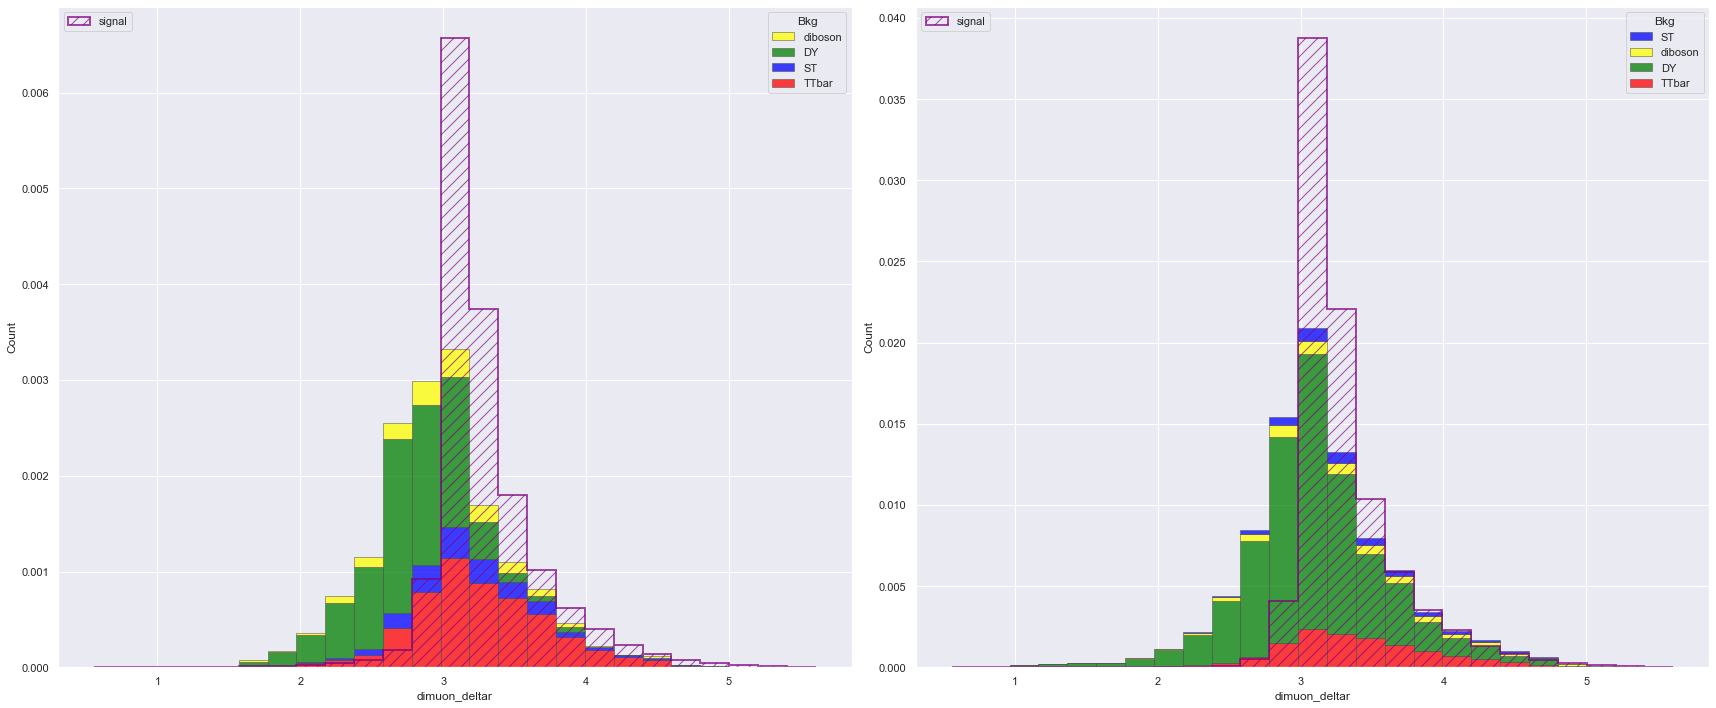

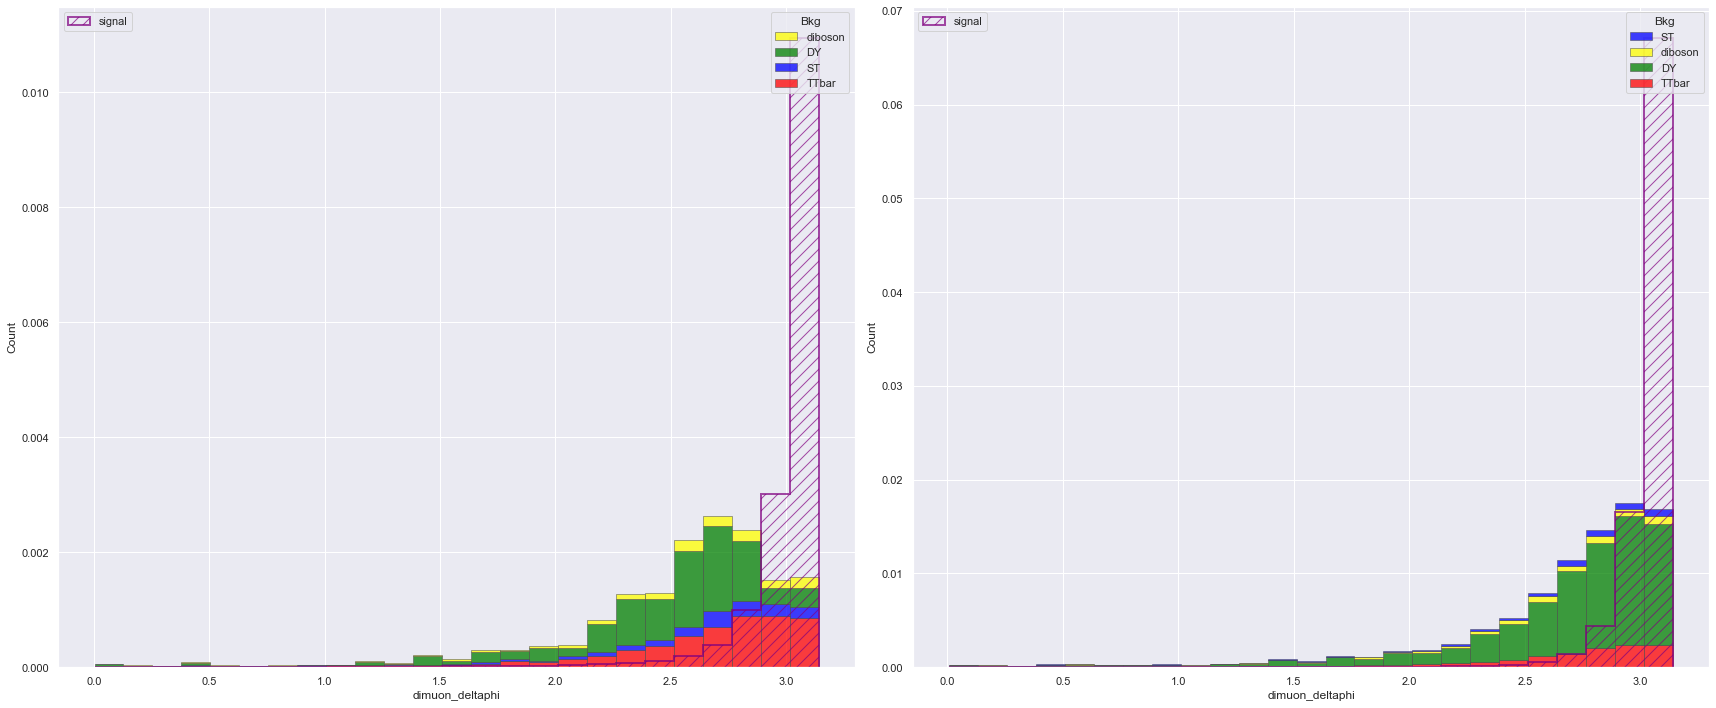

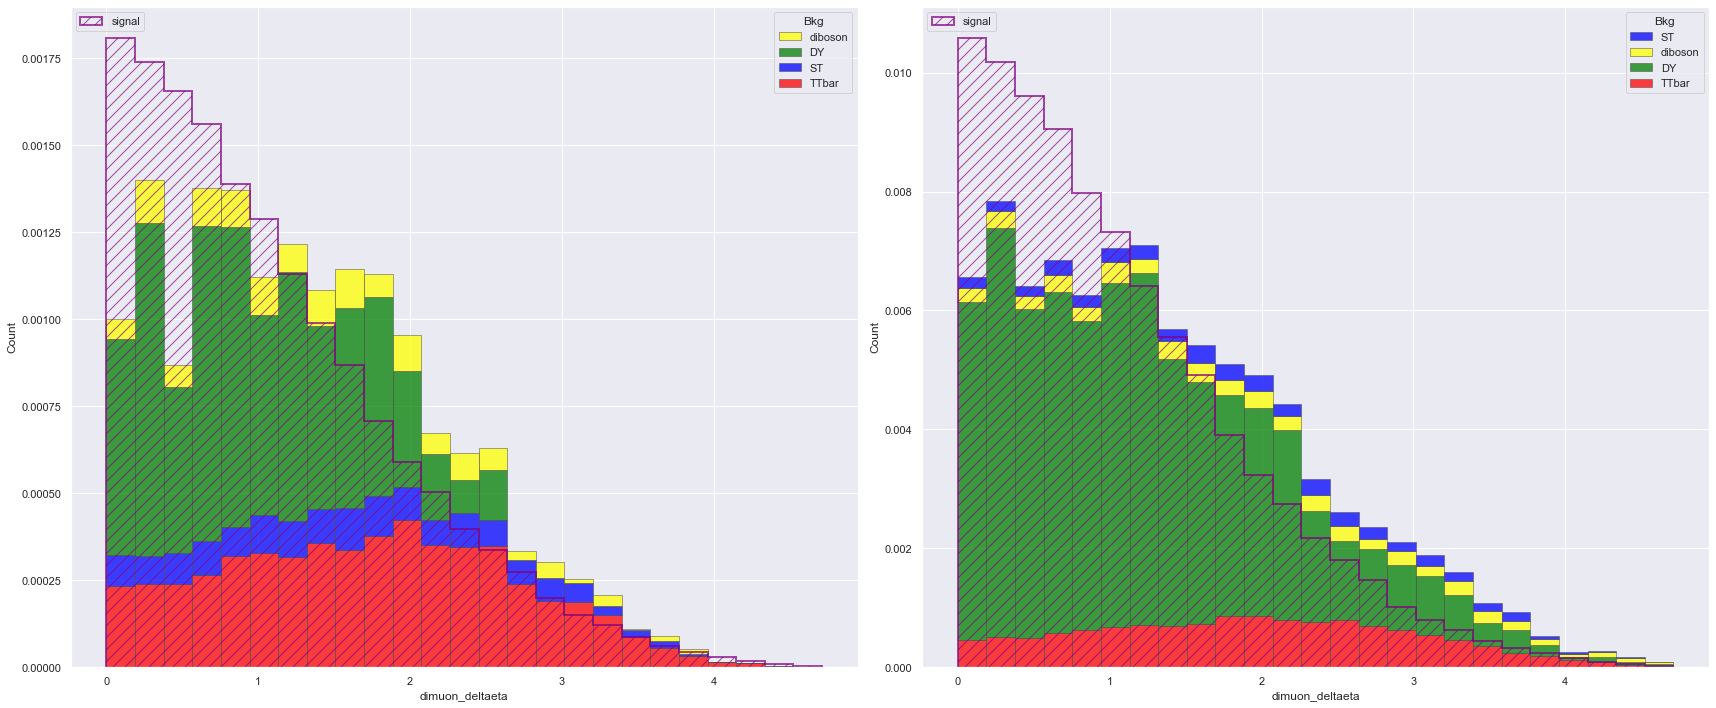

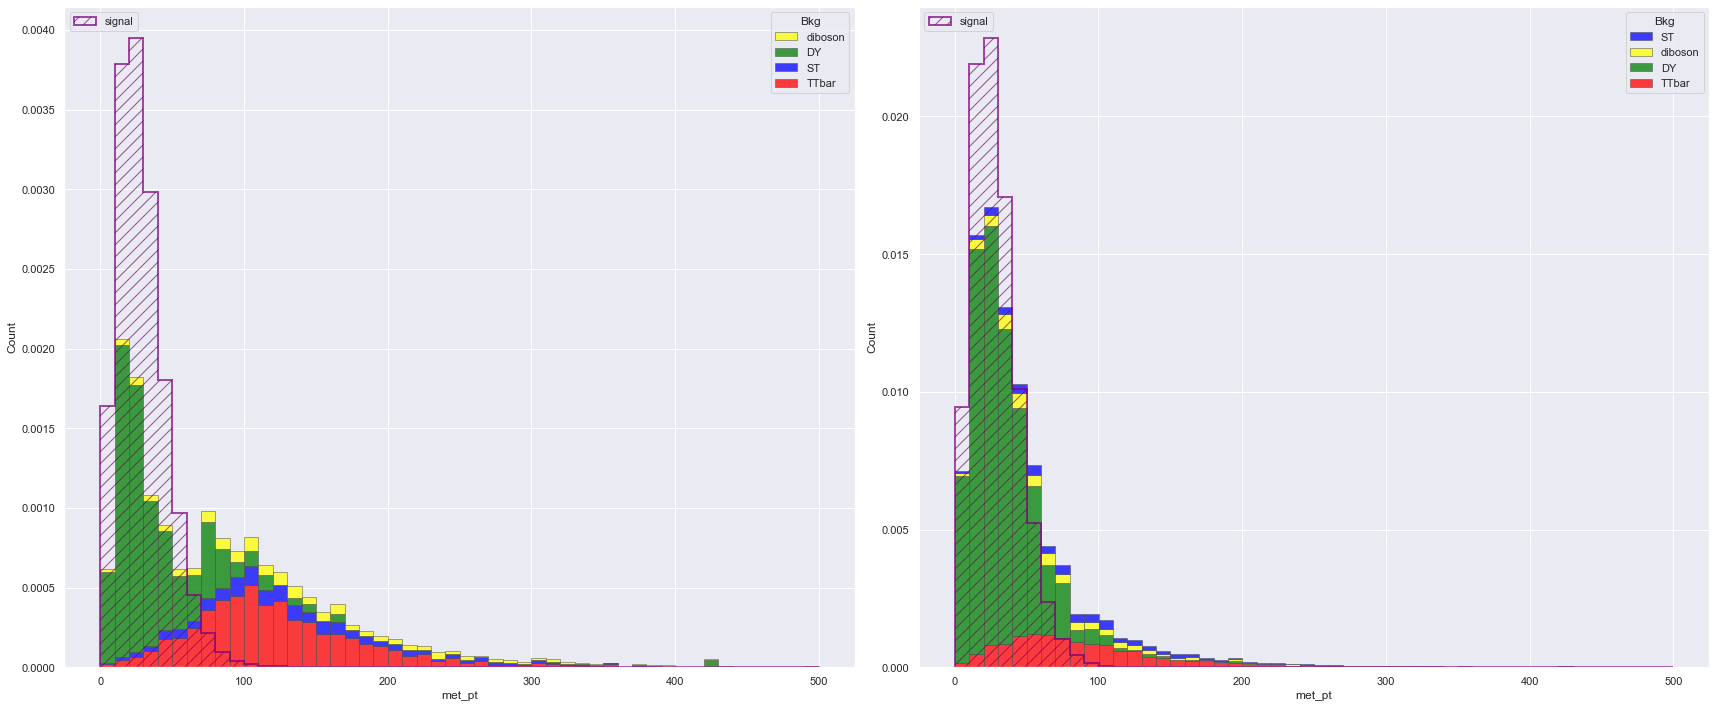

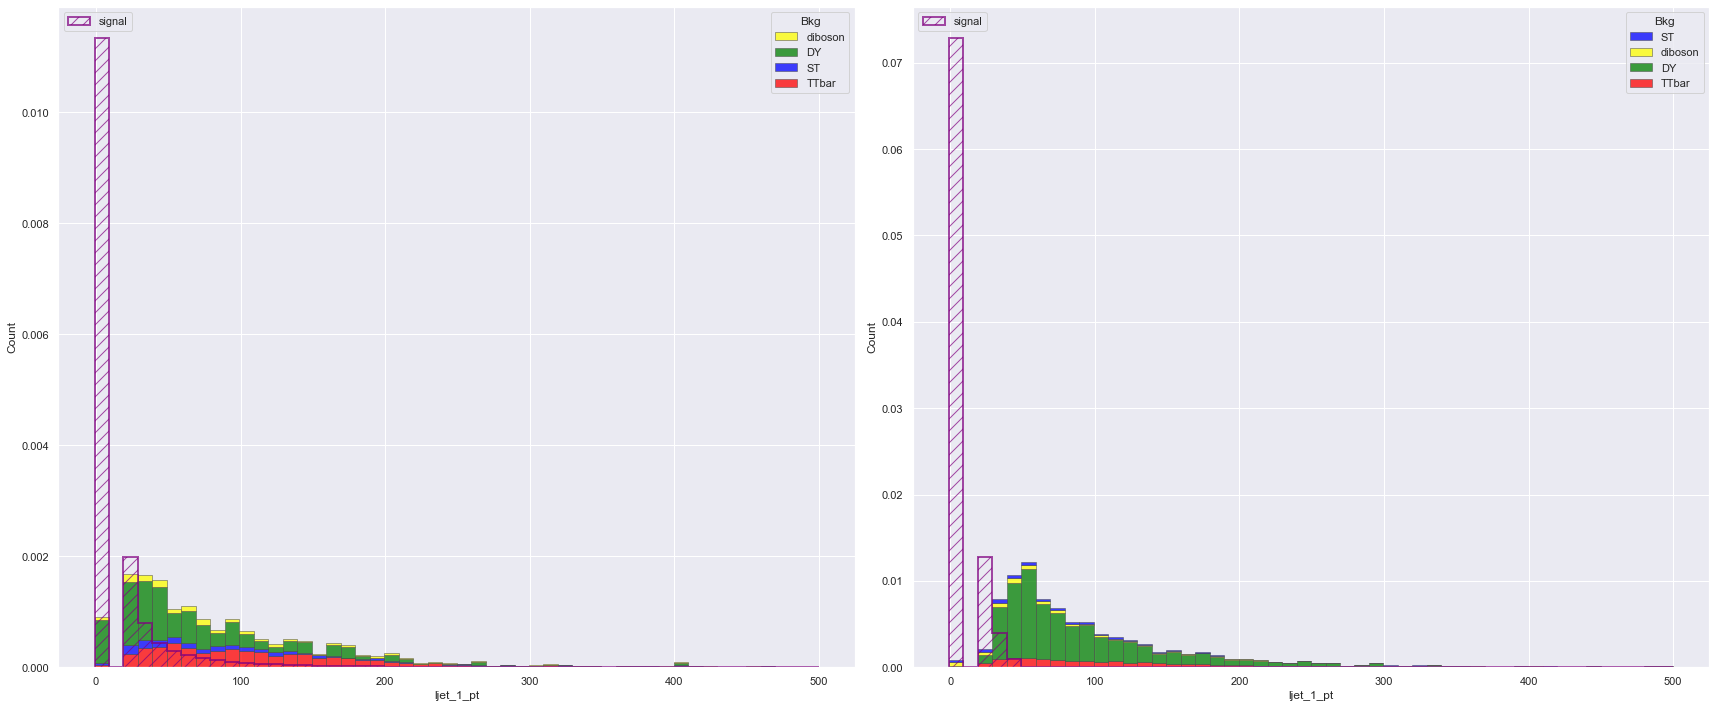

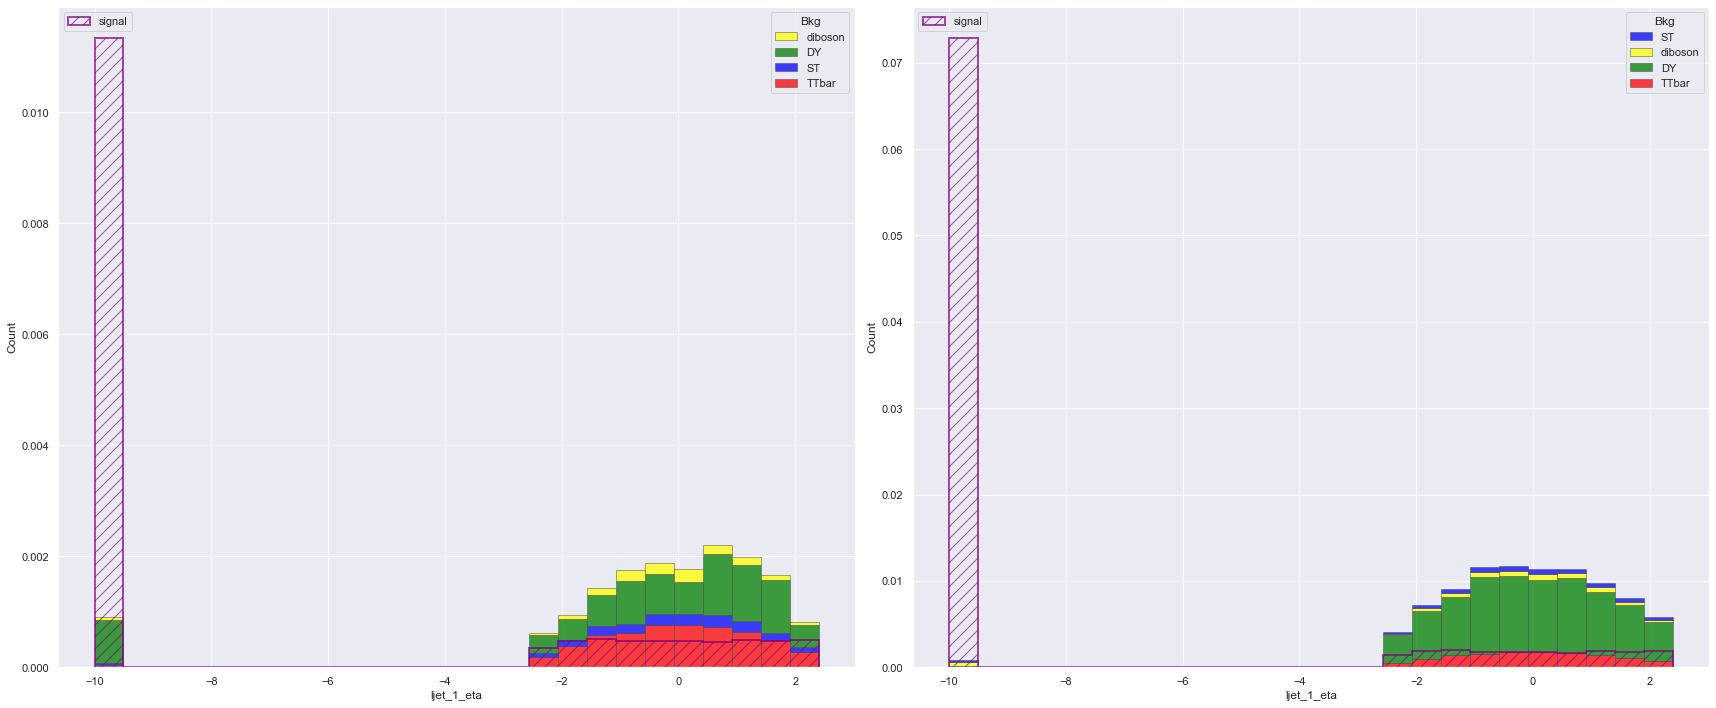

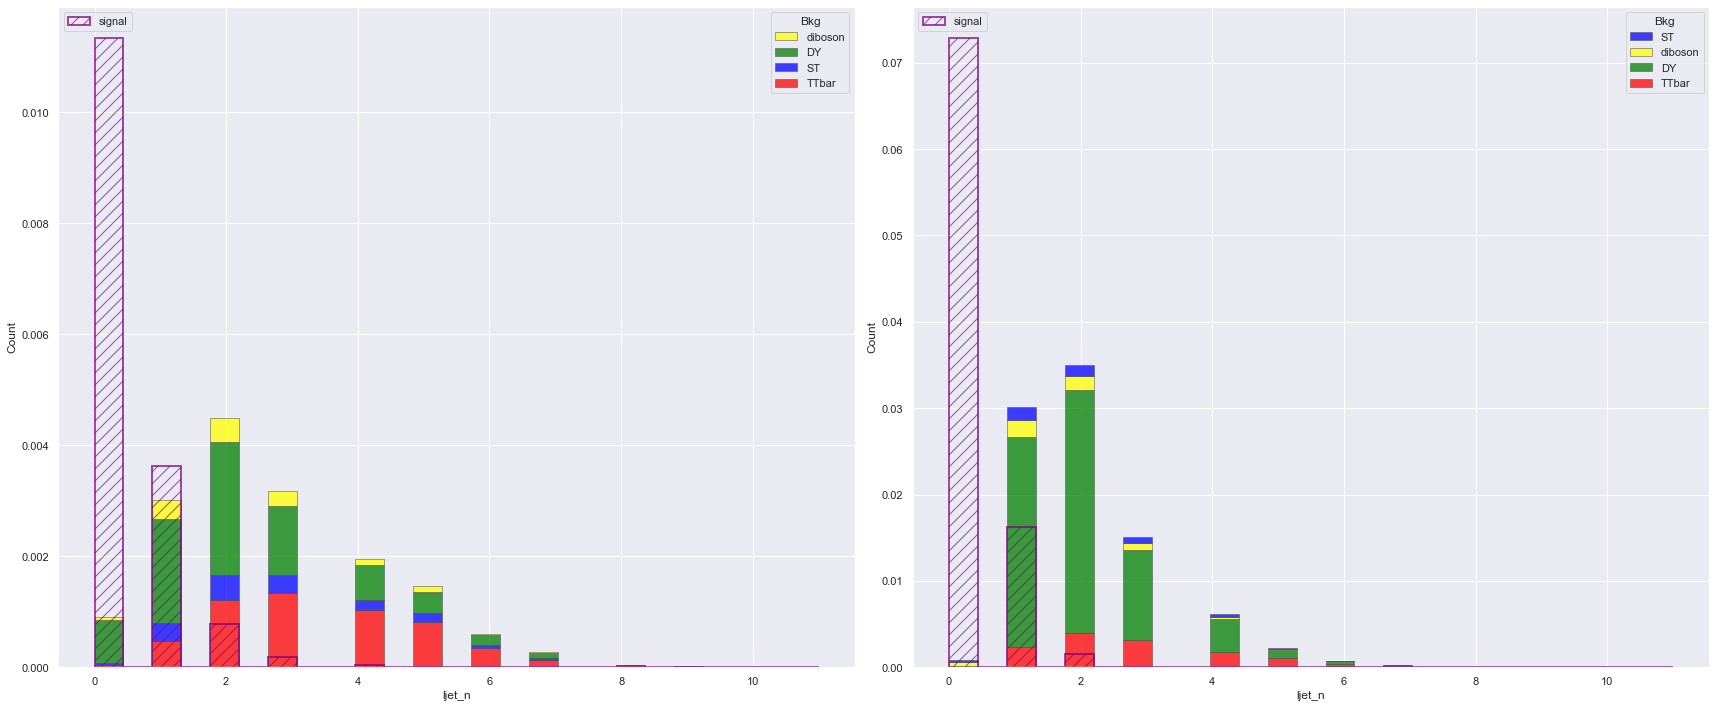

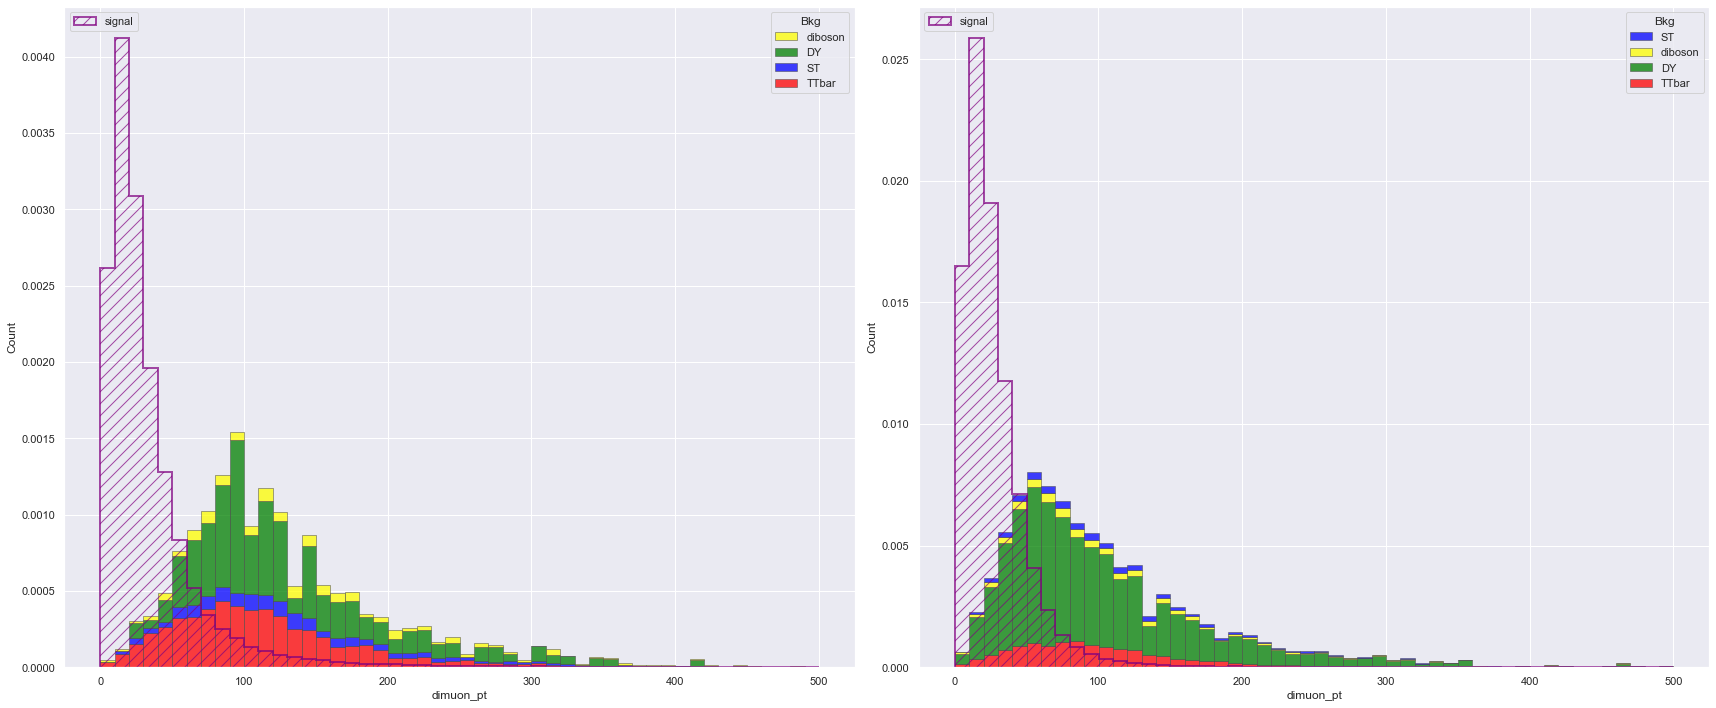

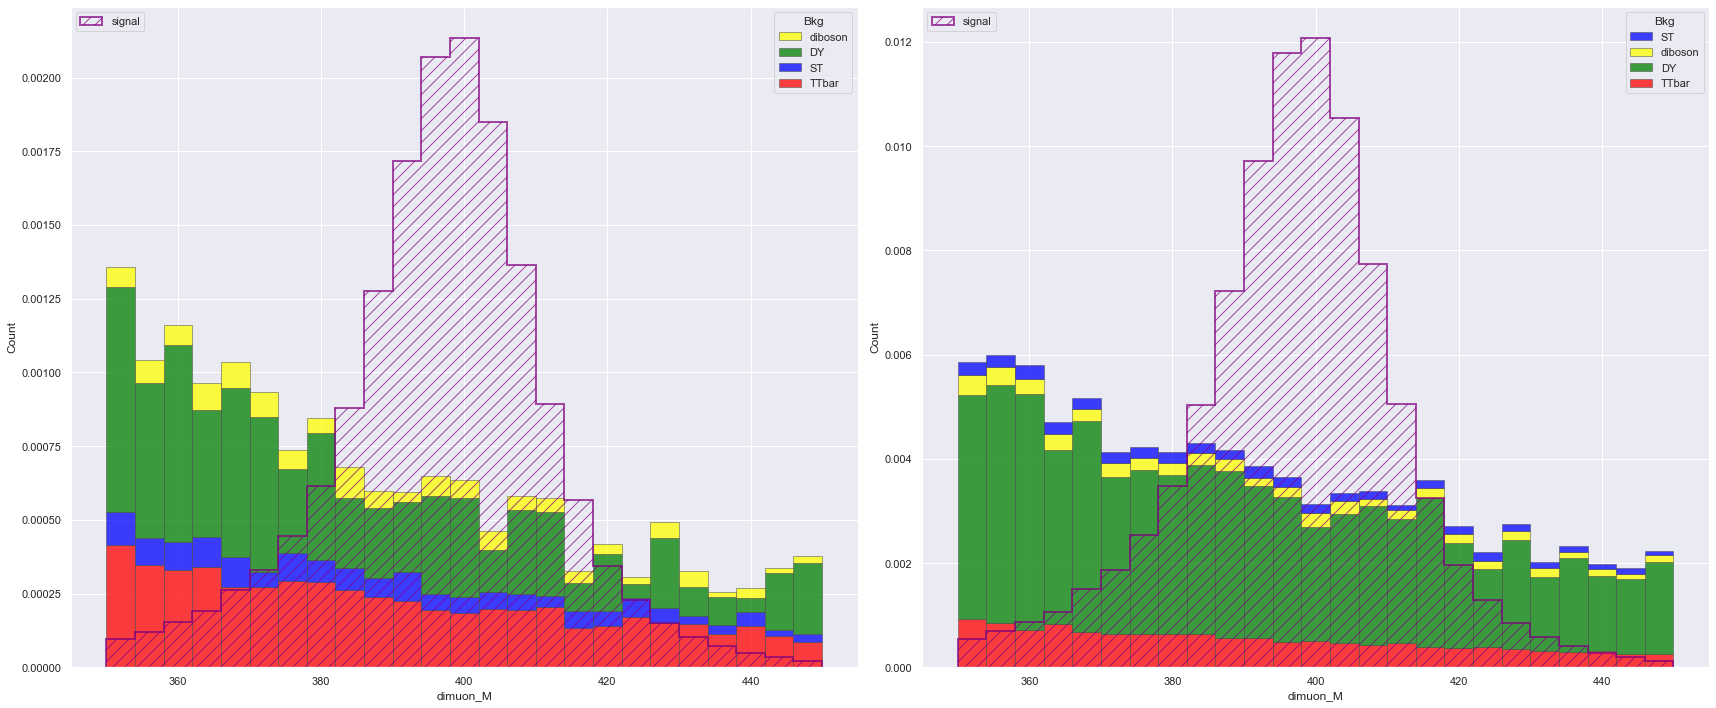

In [21]:
posteriori_plot(data, models=(model1, model2), 
                variables=VAR_CAT2 + ['dimuon_pt', 'dimuon_M'], mass=400.0, 
                cuts=(0.474, 0.684), category=2, case=2, weight=True, share_y=False,
                path='plot/plot/category 2/bbH/performance/weighted', save='comparison')